## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the Norway dataset. B. part is transfer learning with Swiss/GLAMOS train set and Norway test set

### Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import numpy as np

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 32
Number of winter, summer and annual samples: 6275
Number of annual samples: 3184
Number of winter samples: 3091
Number of summer samples: 0


Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

###### Transform into monthly and add ERA5Land

In [4]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='NOR_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-06-11 20:10:04,577 - INFO - Number of annual and seasonal samples: 6275
2025-06-11 20:10:04,579 - INFO - Running on 32 glaciers:
['Langfjordjoekulen' 'Rundvassbreen' 'Engabreen' 'Aalfotbreen'
 'Hansebreen' 'Nigardsbreen' 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen'
 'Rembesdalskaaka' 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Svartisheibreen' 'Trollbergdalsbreen'
 'Vetlefjordbreen' 'Harbardsbreen' 'Storglombreen N' 'Graafjellsbrea'
 'Breidablikkbrea' 'Graasubreen' 'Blaaisen' 'Blabreen' 'Ruklebreen'
 'Cainhavarre' 'Tunsbergdalsbreen' 'Vesledalsbreen' 'Austre Memurubreen'
 'Vestre Memurubreen' 'Hoegtuvbreen' 'Bondhusbrea']
2025-06-11 20:10:04,597 - INFO - Number of annual samples: 3184
2025-06-11 20:10:04,599 - INFO - Number of winter samples: 3091
2025-06-11 20:10:04,599 - INFO - Adding climate features...
2025-06-11 20:10:29,904 - INFO - Converting to monthly resolution...
2025-06-11 20:10:46,543 - INFO - Number of monthly rows: 60056
2025-06-11 

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2013   21.77702   70.12589          -4.92        341.344485   
1  2013   21.77702   70.12589          -4.92        341.344485   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            129.655515              471  RGI60-08.01258   
1            129.655515              471  RGI60-08.01258   

                                            POINT_ID  ID  ...  \
0  Langfjordjoekulen_2013_annual_70.12589_21.7770...   0  ...   
1  Langfjordjoekulen_2013_annual_70.12589_21.7770...   0  ...   

   consensus_ice_thickness       t2m        tp      slhf      sshf       ssrd  \
0                96.980293 -0.428070  0.003846  -55354.0  657502.0  2040907.0   
1                96.980293 -4.780853  0.003902  178386.0  909366.0   157664.0   

        fal        str       u10       v10  
0  0.439741 -2504336.0 -0.141248  0.397857  
1  0.817481 -1714196.0 -0.183276  1.758524  

[2 rows x 27 columns]

#### A.2. Dataset statistics

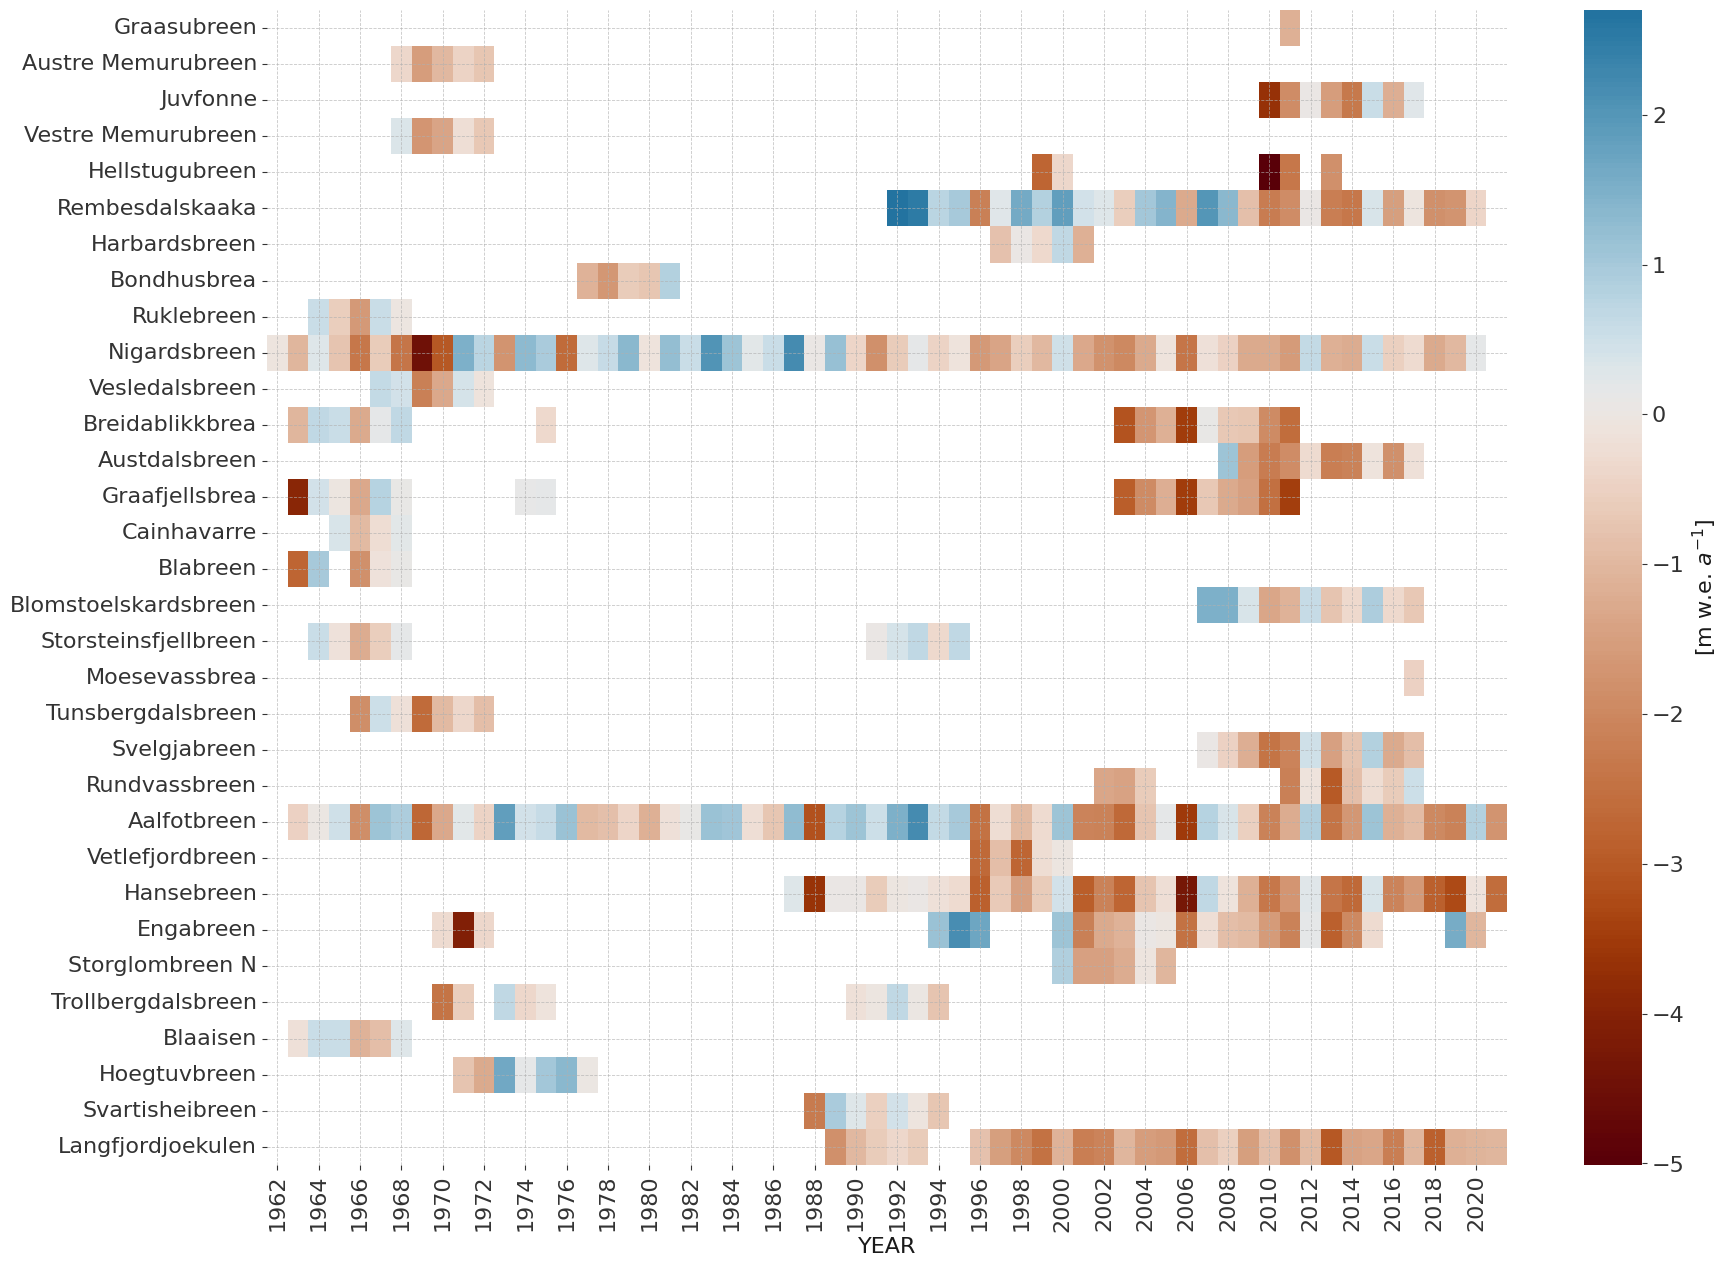

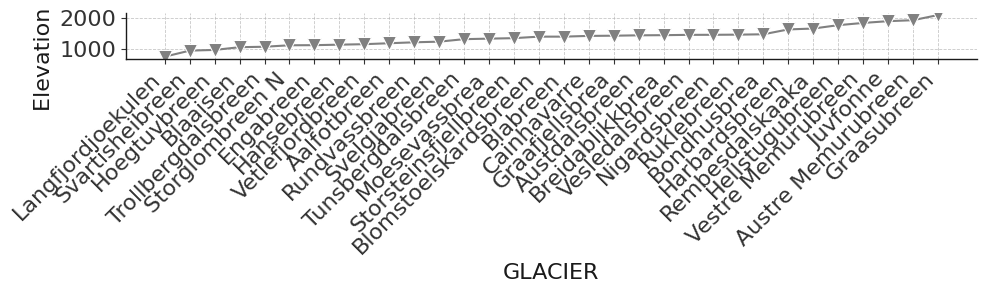

In [5]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

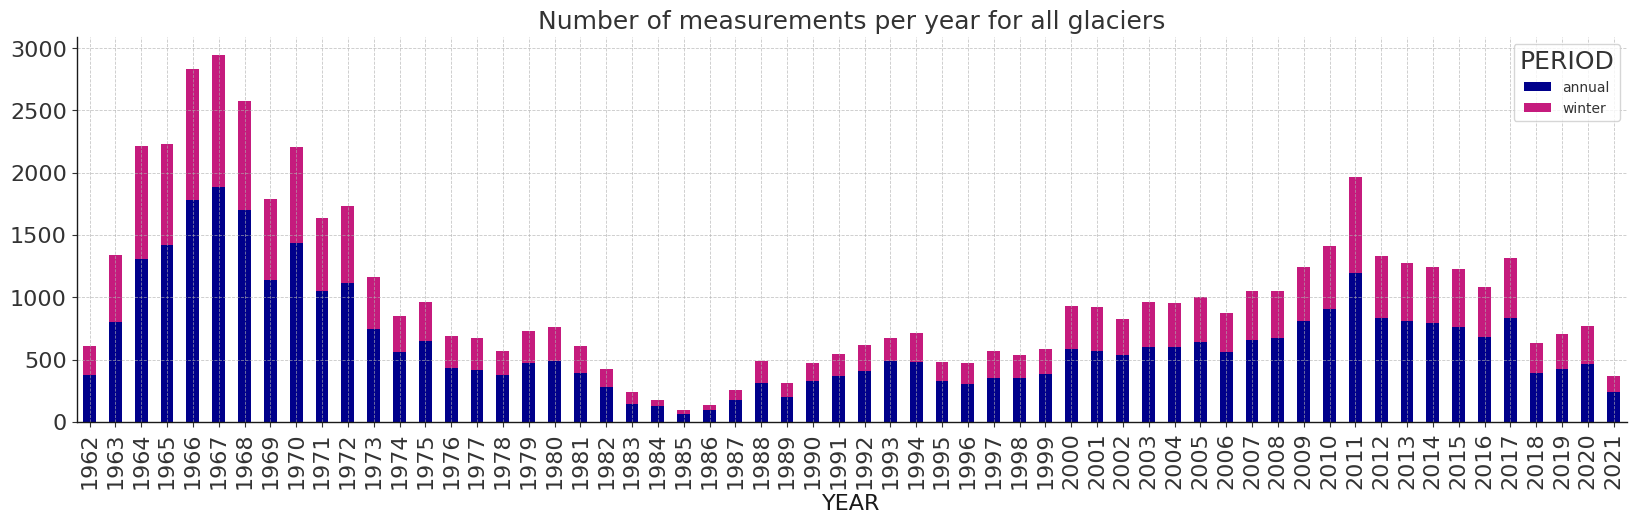

In [6]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

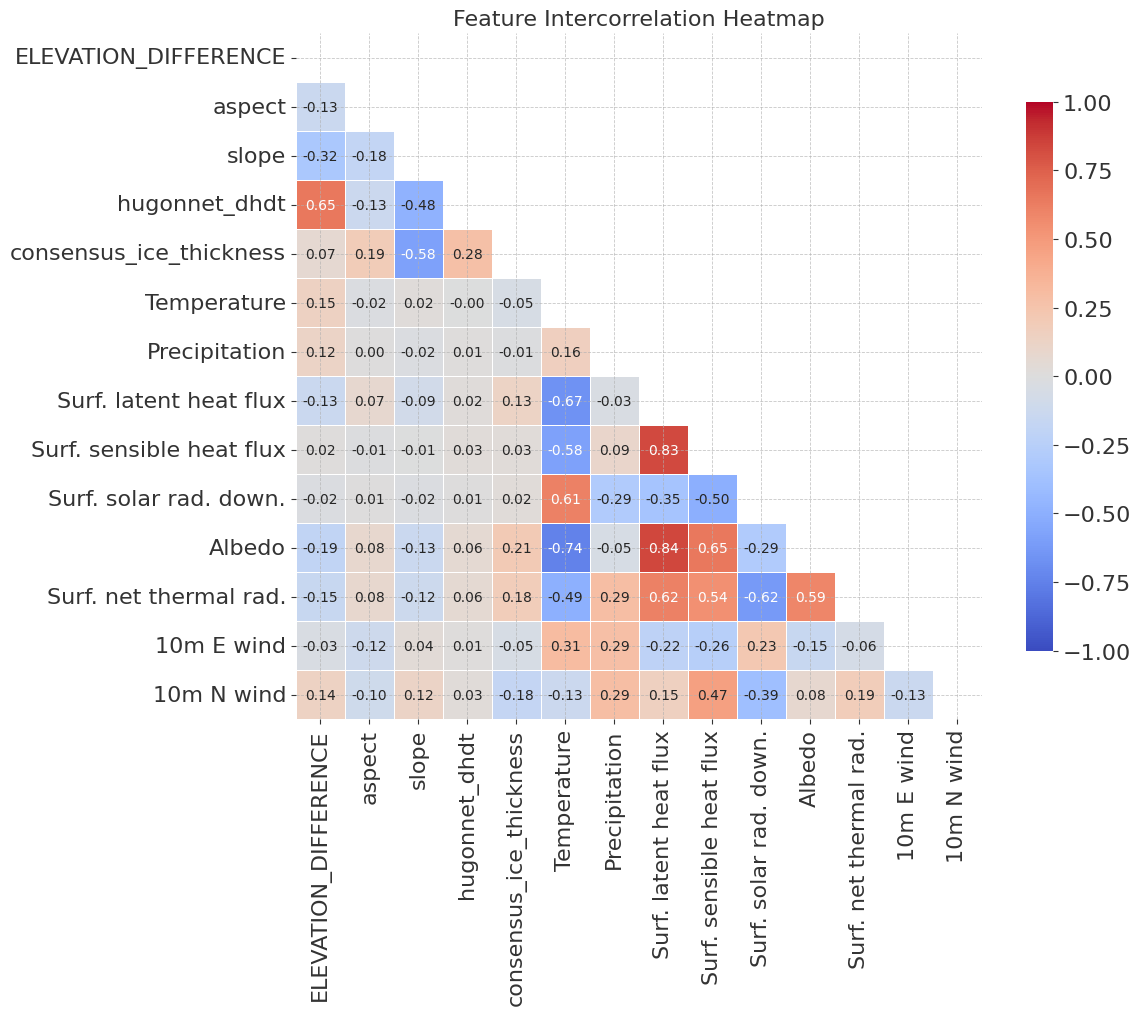

In [7]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)


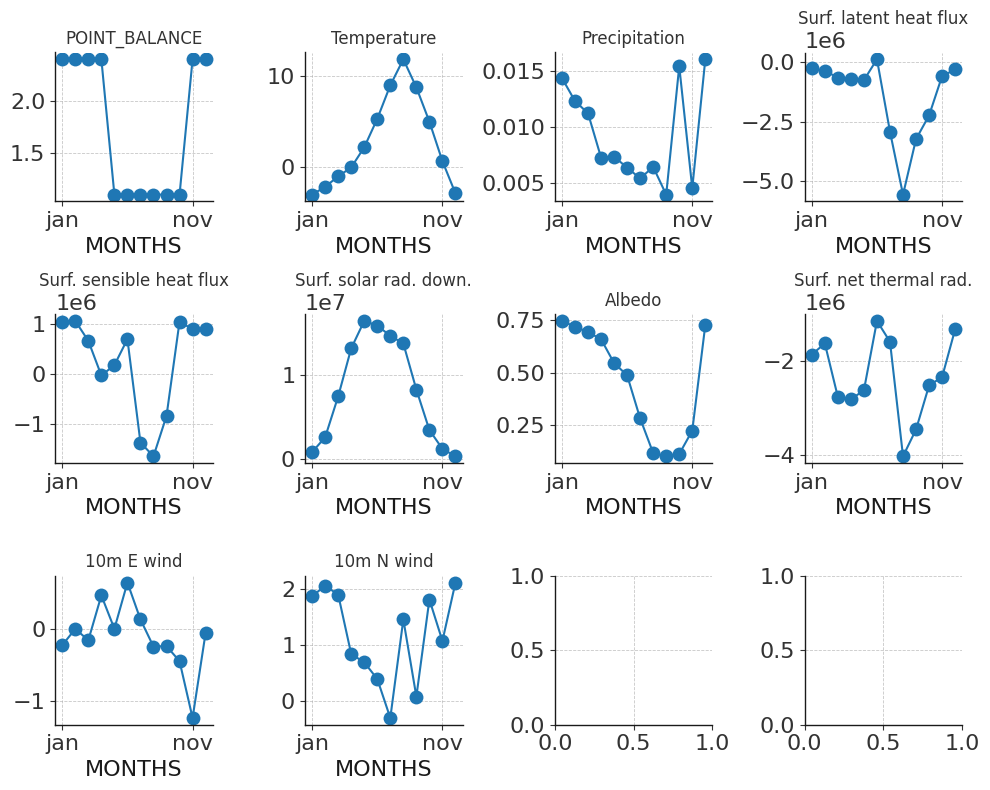

In [8]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Aalfotbreen') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

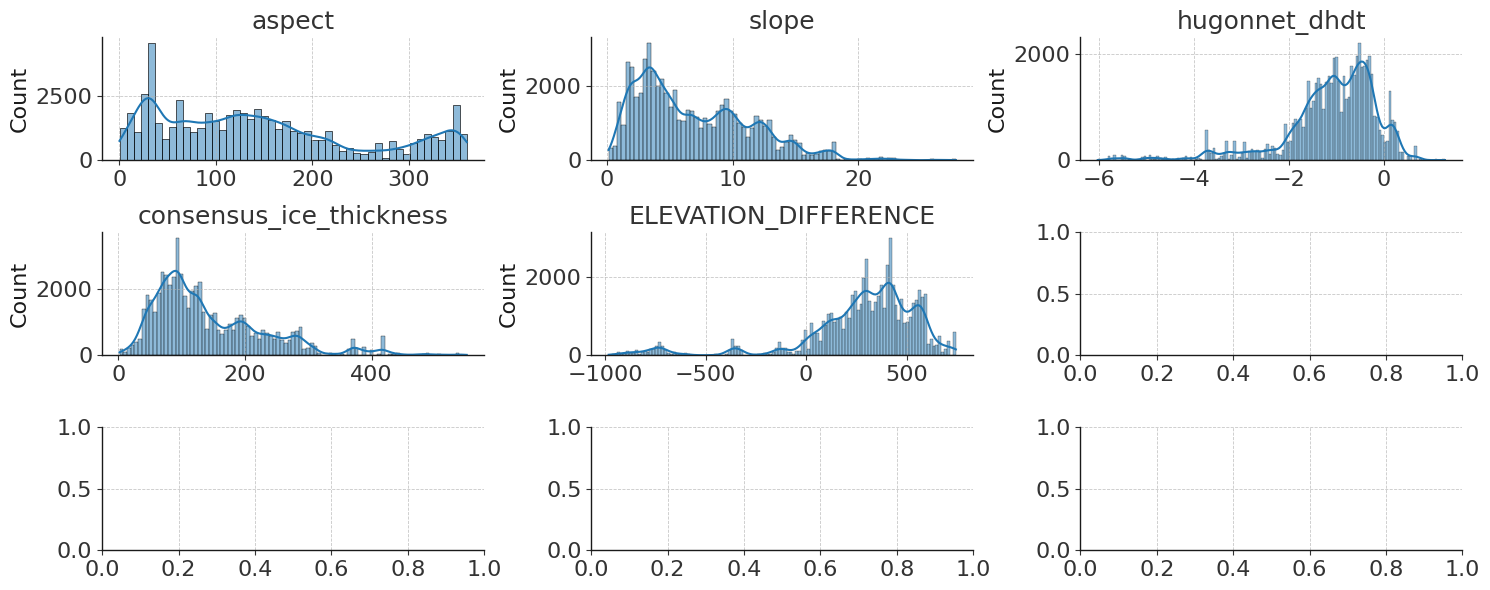

In [9]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

### A.3. Train-test set split:
##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

###### This test set is the same used in the Norway paper

In [10]:
## find RGIId of Glaciers Kamilla used as test set

glacier_list_df = pd.read_csv(cfg.dataPath + path_PMB_WGMS_raw +'glaciological_point_mass_balance_Norway.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv')

# breid ids that Kamilla used as test set
breid_list = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]


breid_to_rgiid = {}
for breid in breid_list:
    matching_row = glacier_list_df[glacier_list_df['breid'] == breid]
    rgiid = matching_row['rgiid'].iloc[0]
    breid_to_rgiid[breid] = rgiid


# Display the mapping
print("Mapping from breid to RGI ID:")
for breid, rgiid in breid_to_rgiid.items():
    print(f"{breid}: {rgiid}")

# Create a list of just the RGI IDs for easy use
test_rgiids = list(breid_to_rgiid.values())
print("\nList of test RGI IDs:")
print(test_rgiids)

rgi_to_glacier = {}

for rgi_id in test_rgiids:
    matching_rows = data_NOR[data_NOR['RGIId'] == rgi_id]
    glacier_name = matching_rows['GLACIER'].iloc[0]
    rgi_to_glacier[rgi_id] = glacier_name


print("RGI ID to Glacier Name mapping:")
for rgi_id, glacier_name in rgi_to_glacier.items():
    print(f"{rgi_id}: {glacier_name}")

norway_kamilla_glacierlist = list(rgi_to_glacier.values())
print("\nList of test RGI IDs:")
print(norway_kamilla_glacierlist)

Mapping from breid to RGI ID:
54: RGI60-08.01258
703: RGI60-08.01026
941: RGI60-08.02384
1135: RGI60-08.01598
1280: RGI60-08.01484
2085: RGI60-08.02650
2320: RGI60-08.00434
2478: RGI60-08.01286
2768: RGI60-08.00449
2769: RGI60-08.01013
3133: RGI60-08.02916
3137: RGI60-08.02918
3138: RGI60-08.02920
3141: RGI60-08.02969

List of test RGI IDs:
['RGI60-08.01258', 'RGI60-08.01026', 'RGI60-08.02384', 'RGI60-08.01598', 'RGI60-08.01484', 'RGI60-08.02650', 'RGI60-08.00434', 'RGI60-08.01286', 'RGI60-08.00449', 'RGI60-08.01013', 'RGI60-08.02916', 'RGI60-08.02918', 'RGI60-08.02920', 'RGI60-08.02969']
RGI ID to Glacier Name mapping:
RGI60-08.01258: Langfjordjoekulen
RGI60-08.01026: Cainhavarre
RGI60-08.02384: Rundvassbreen
RGI60-08.01598: Svartisheibreen
RGI60-08.01484: Trollbergdalsbreen
RGI60-08.02650: Hansebreen
RGI60-08.00434: Tunsbergdalsbreen
RGI60-08.01286: Austdalsbreen
RGI60-08.00449: Hellstugubreen
RGI60-08.01013: Austre Memurubreen
RGI60-08.02916: Bondhusbrea
RGI60-08.02918: Svelgjabreen

In [11]:
"""
test_glaciers = [
    'Vestre Memurubreen', 'Rembesdalskaaka',
    'Blabreen', 'Graafjellsbrea', 'Breidablikkbrea', 'Ruklebreen',
    'Bondhusbrea', 'Svelgjabreen', 'Moesevassbrea',
    'Blomstoelskardsbreen'
]
"""
test_glaciers = norway_kamilla_glacierlist.copy()

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 17288
Size of train data: 42768
Percentage of test size: 40.42%
Train glaciers: (18) ['Engabreen' 'Aalfotbreen' 'Nigardsbreen' 'Juvfonne' 'Rembesdalskaaka'
 'Storsteinsfjellbreen' 'Vetlefjordbreen' 'Harbardsbreen'
 'Storglombreen N' 'Graafjellsbrea' 'Breidablikkbrea' 'Graasubreen'
 'Blaaisen' 'Blabreen' 'Ruklebreen' 'Vesledalsbreen' 'Vestre Memurubreen'
 'Hoegtuvbreen']
Test glaciers: (14) ['Langfjordjoekulen' 'Rundvassbreen' 'Hansebreen' 'Austdalsbreen'
 'Hellstugubreen' 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Svartisheibreen' 'Trollbergdalsbreen' 'Cainhavarre' 'Tunsbergdalsbreen'
 'Austre Memurubreen' 'Bondhusbrea']


##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [ ]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)



print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

##### A.3.3. Train-Test set plots

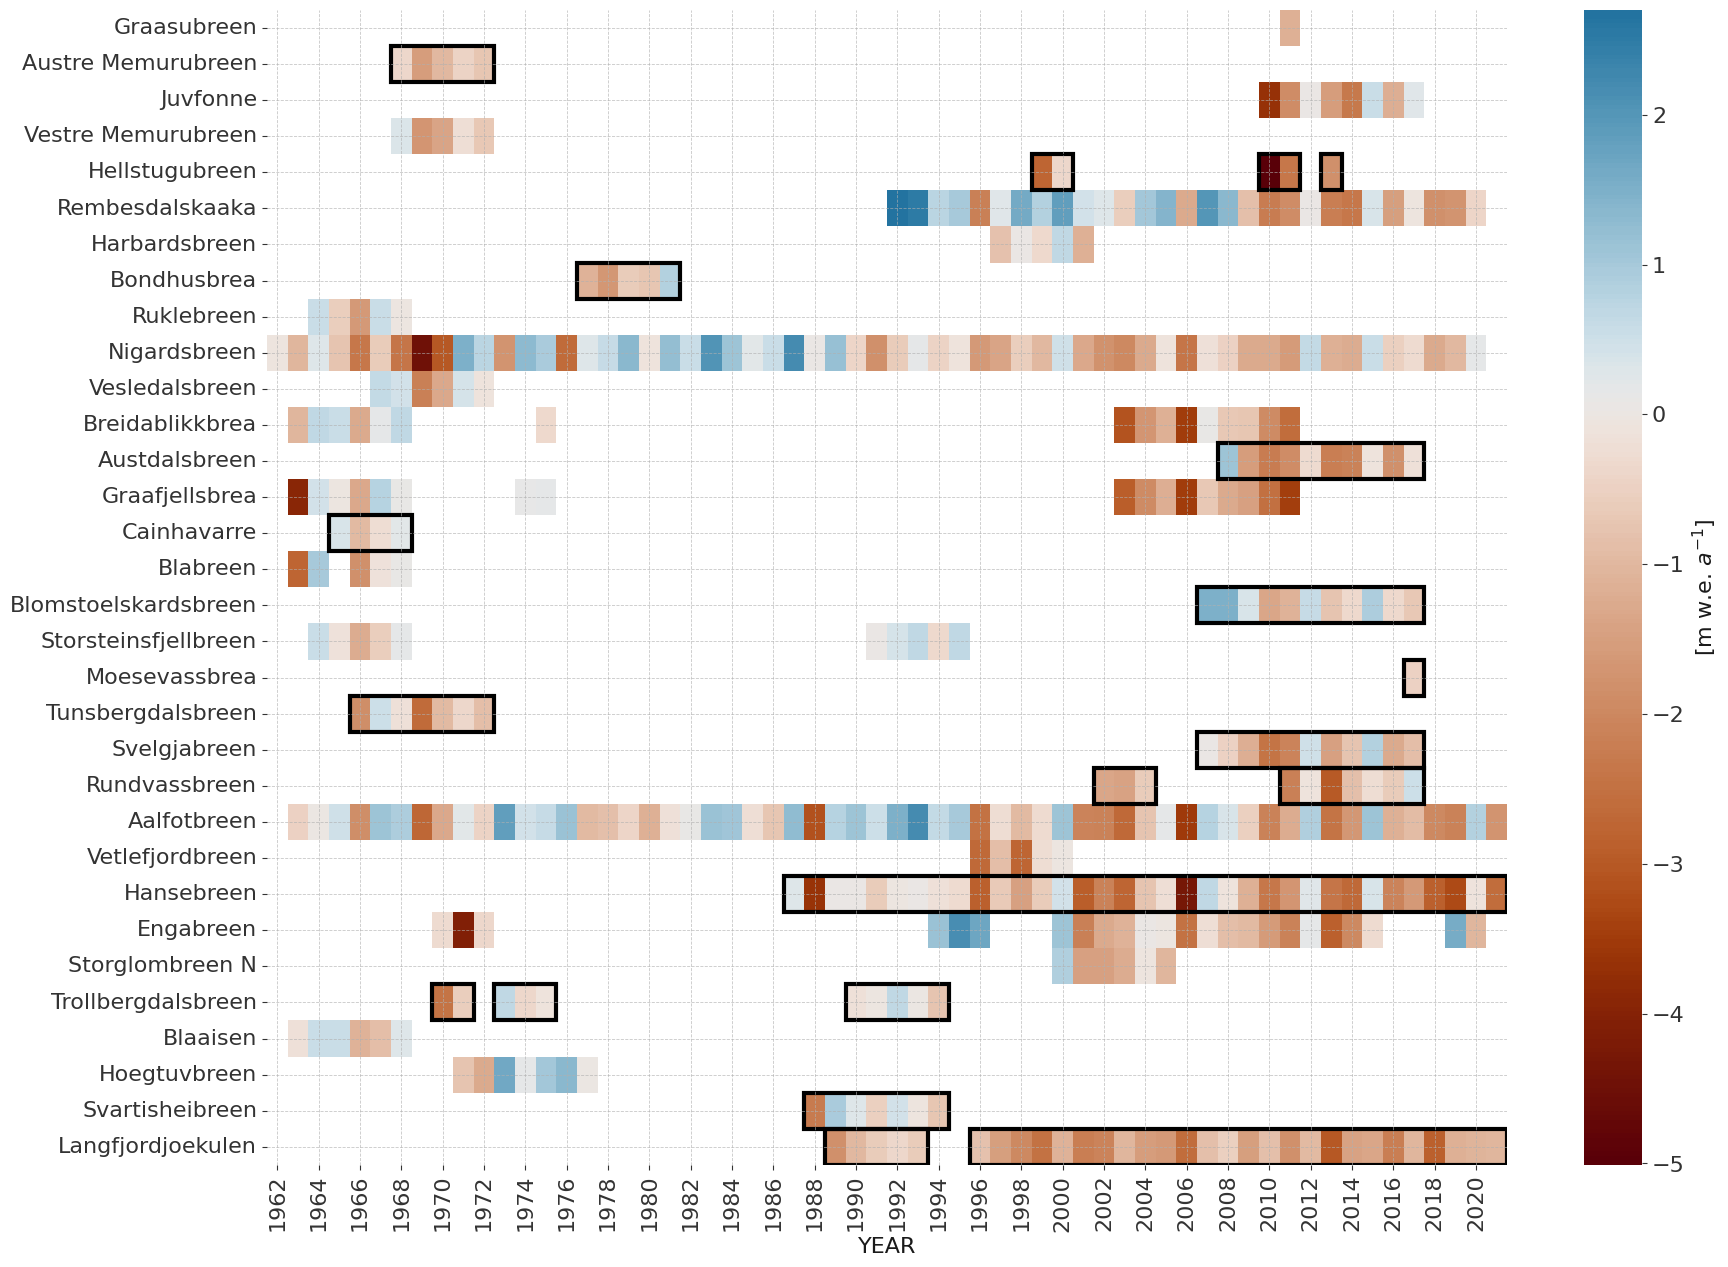

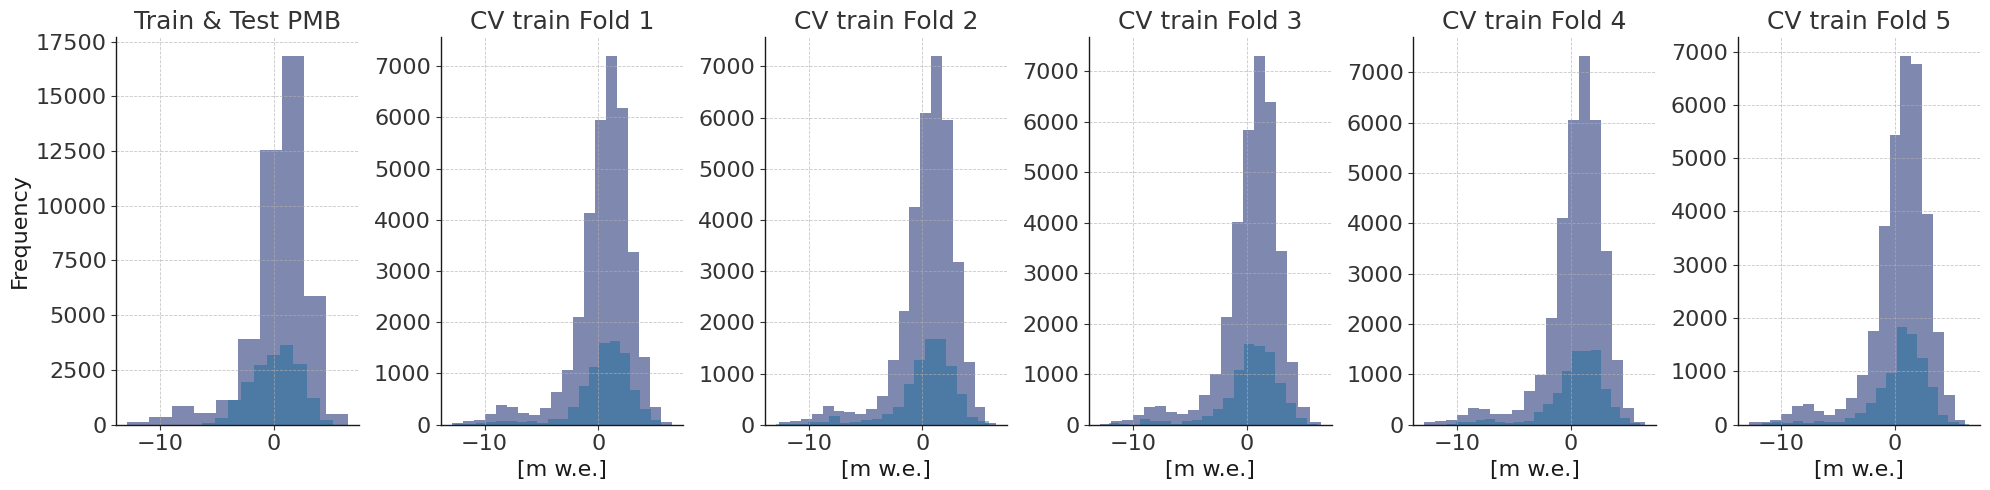

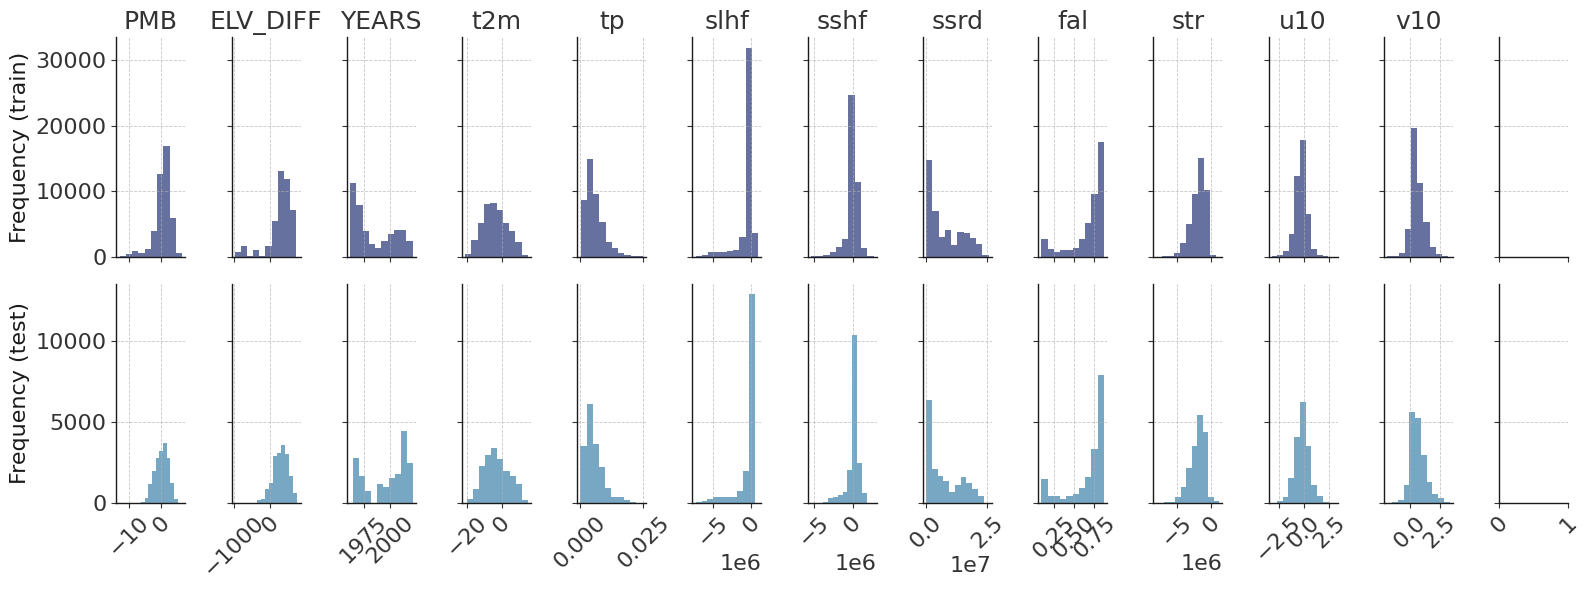

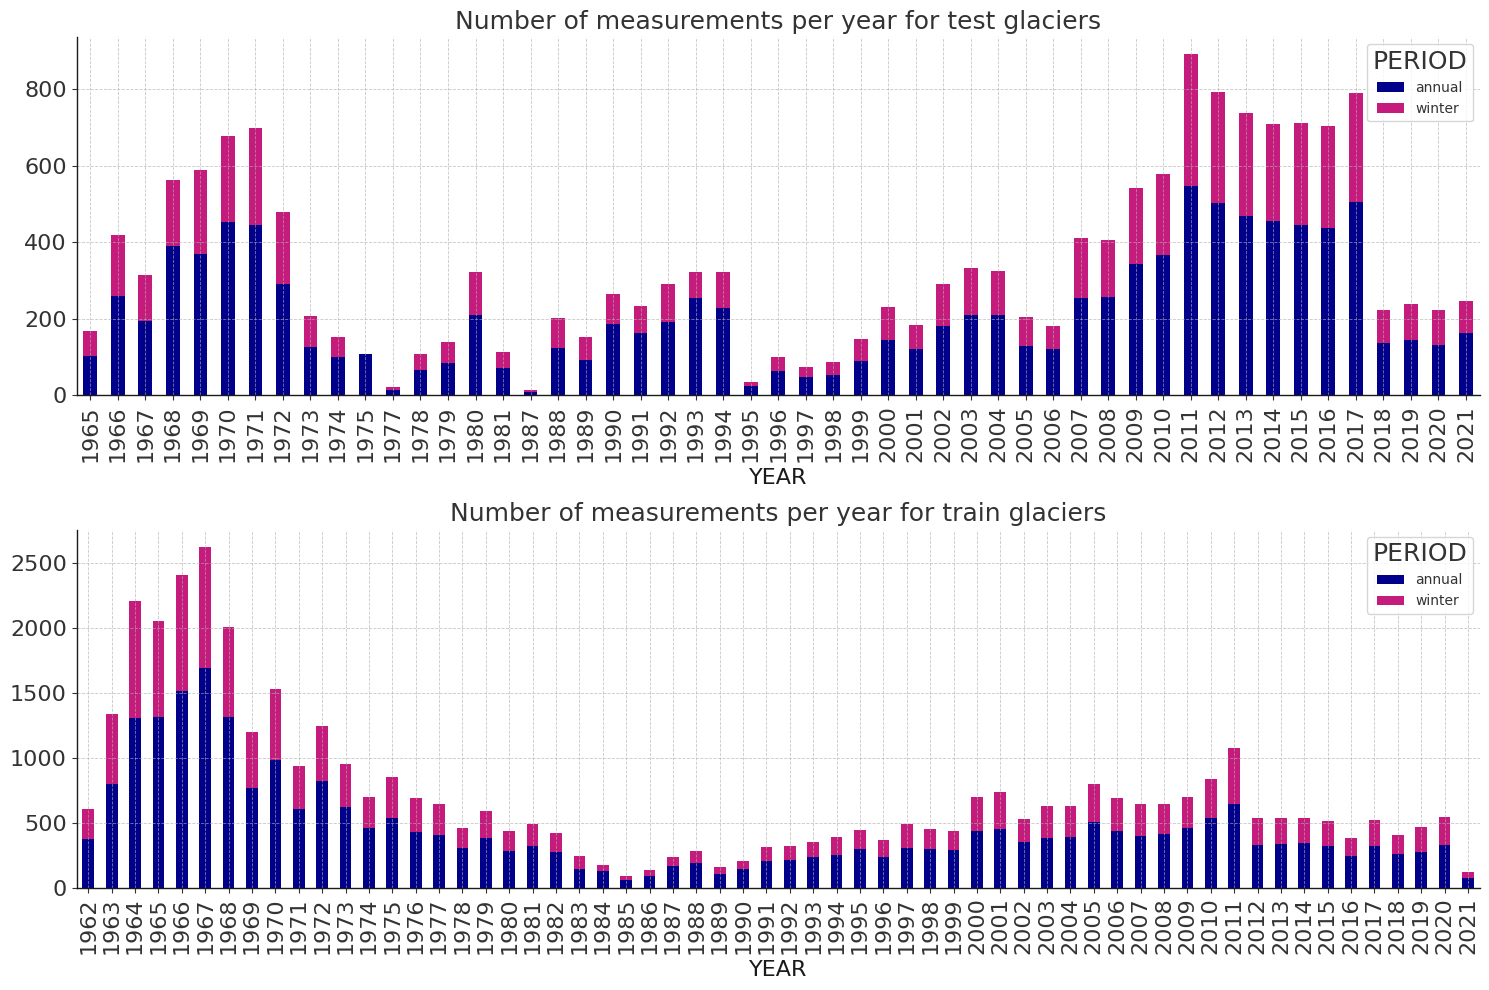

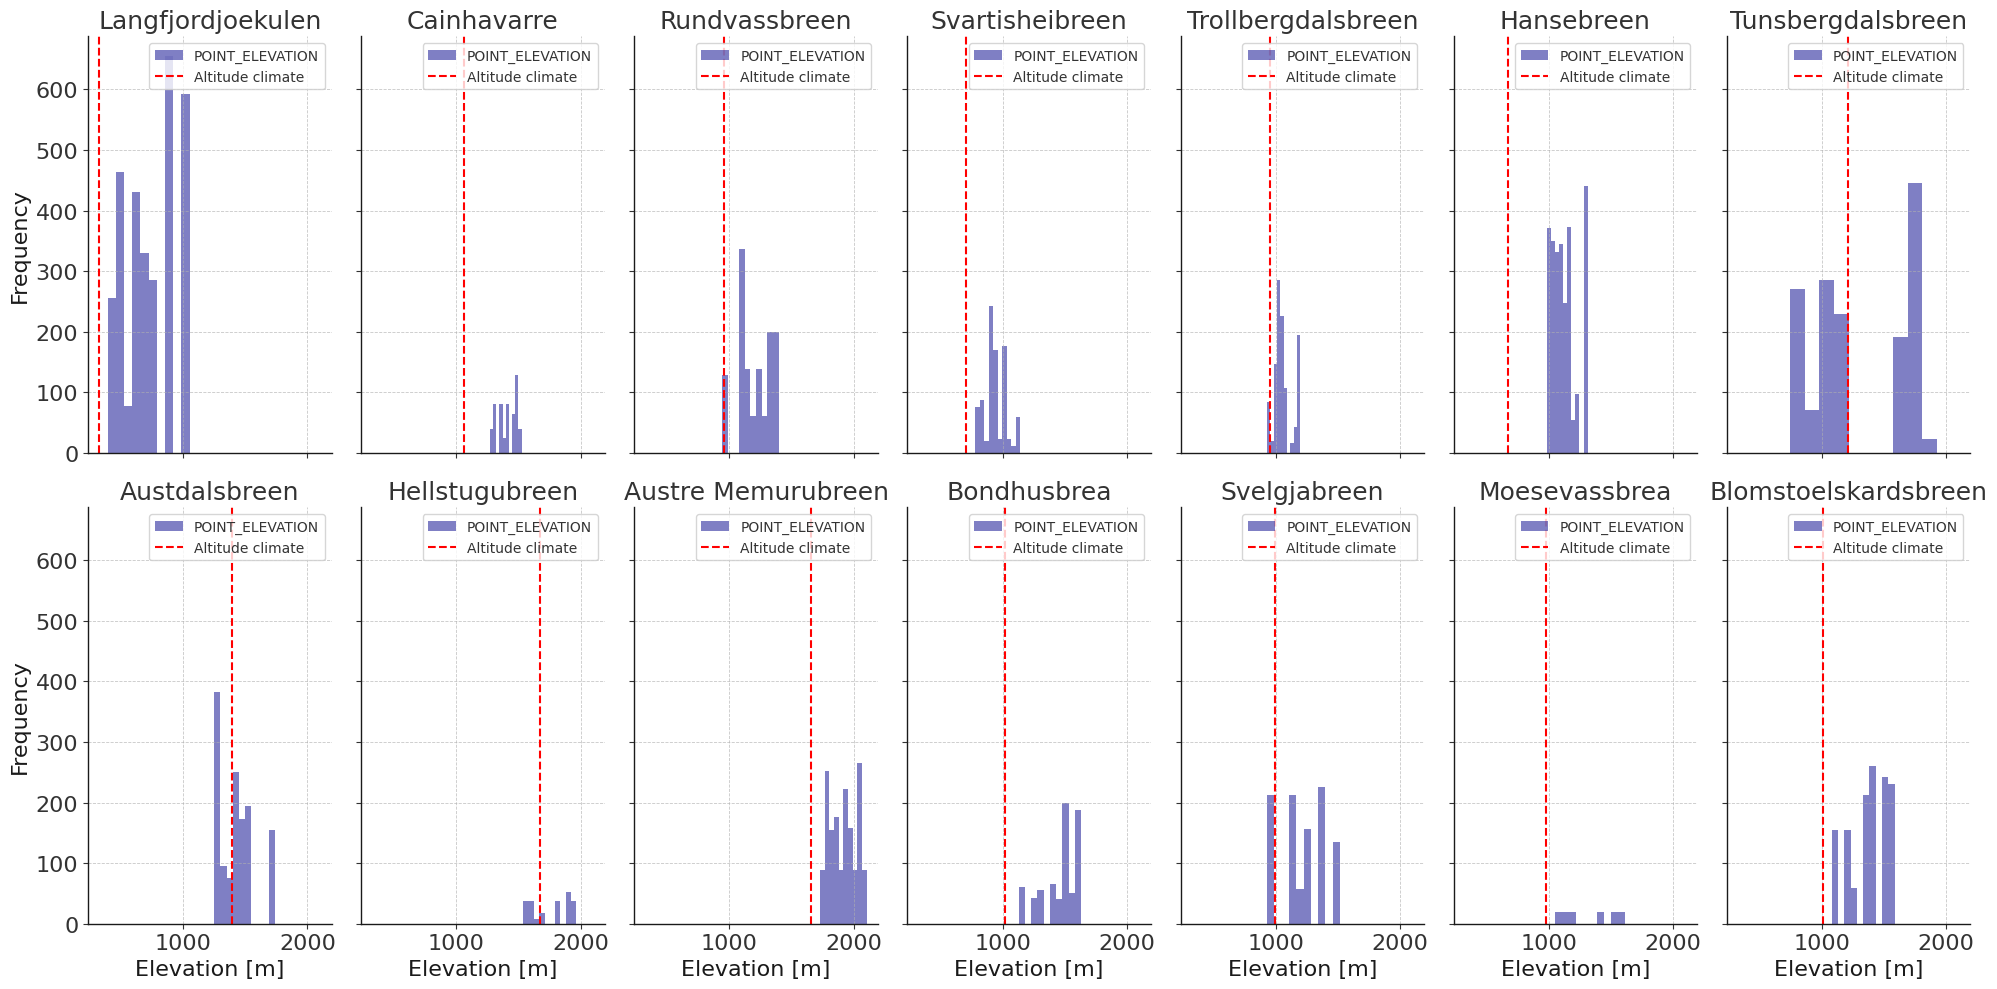

In [12]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### A.4. XGBoost:

In [17]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cpu'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = 11

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
]

###### Grid search:

In [ ]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = True
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Norway_Kamilla.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Norway_Kamilla.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (42768, 25)
Shape of testing dataset: (17288, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/home/mburlet/miniconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:19:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/miniconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:19:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/miniconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:19:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/miniconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:19:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/miniconda3/envs/MassBalanceMachine/lib/pyt

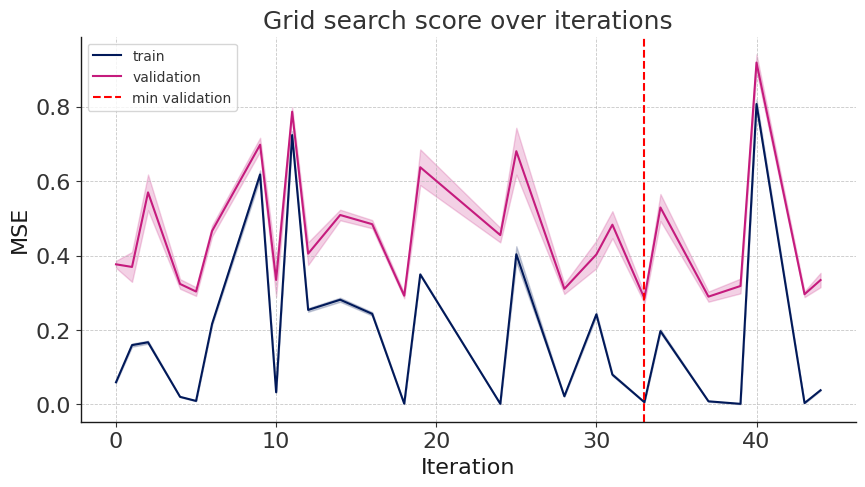

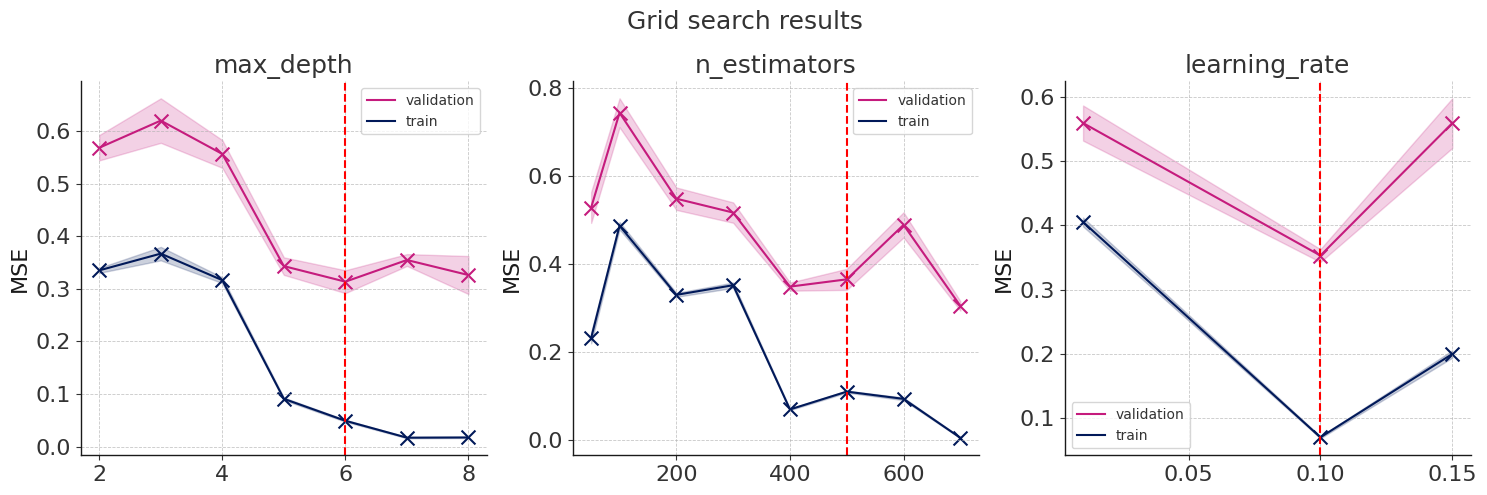

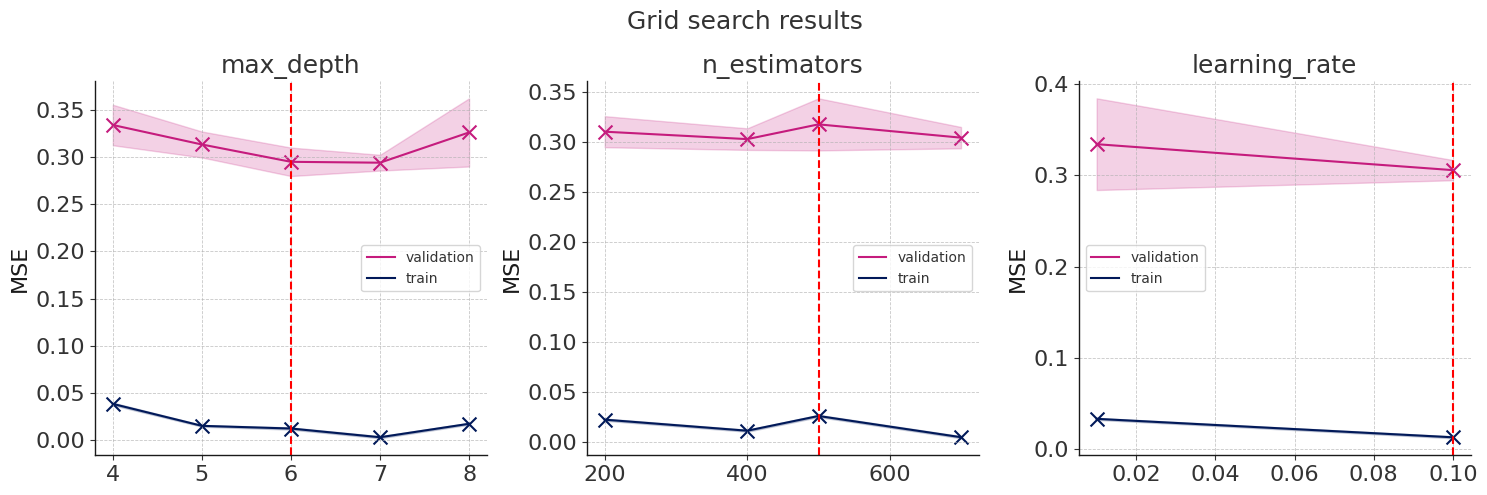

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

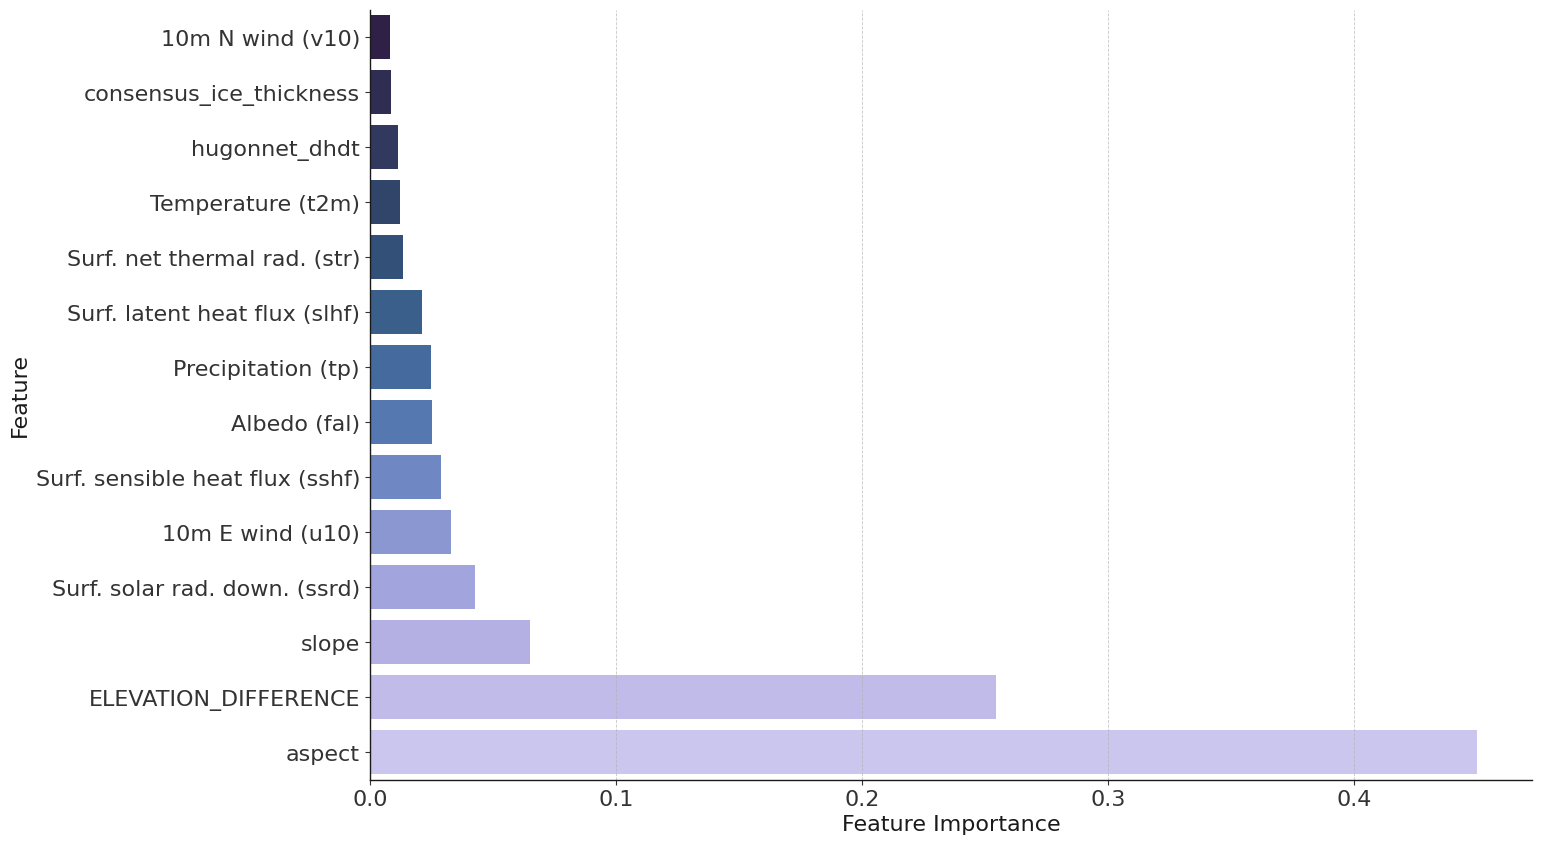

In [18]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters:

Shape of the test: (17309, 14)
{'Langfjordjoekulen': '#a6cee3', 'Cainhavarre': '#1f78b4', 'Rundvassbreen': '#b2df8a', 'Svartisheibreen': '#33a02c', 'Trollbergdalsbreen': '#fb9a99', 'Hansebreen': '#e31a1c', 'Tunsbergdalsbreen': '#fdbf6f', 'Austdalsbreen': '#ff7f00', 'Hellstugubreen': '#cab2d6', 'Austre Memurubreen': '#6a3d9a', 'Bondhusbrea': '#ffff99', 'Svelgjabreen': '#b15928', 'Moesevassbrea': '#8dd3c7', 'Blomstoelskardsbreen': '#ffffb3'}


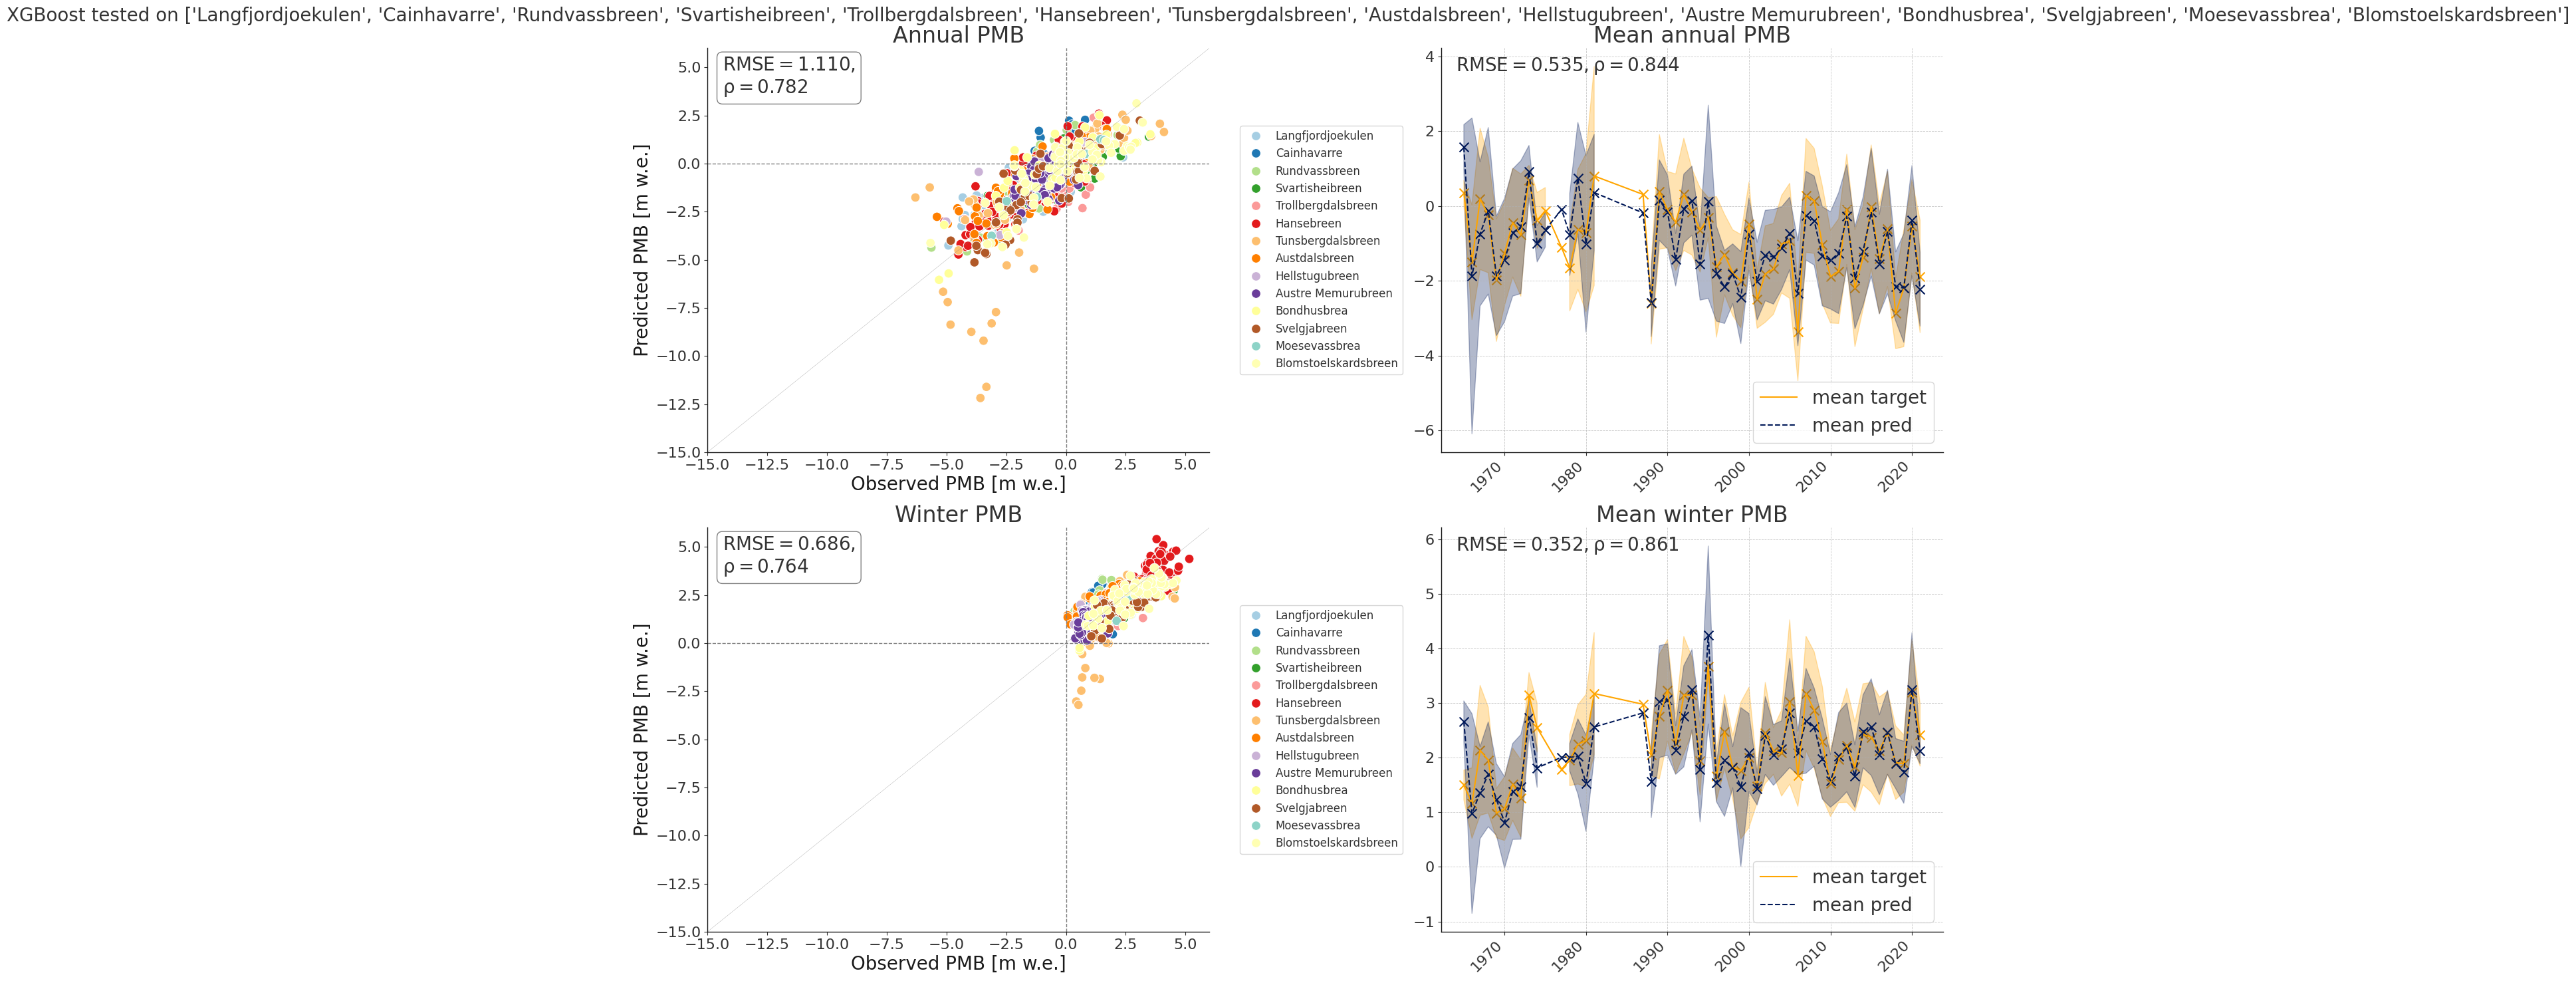

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, include_summer=True)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

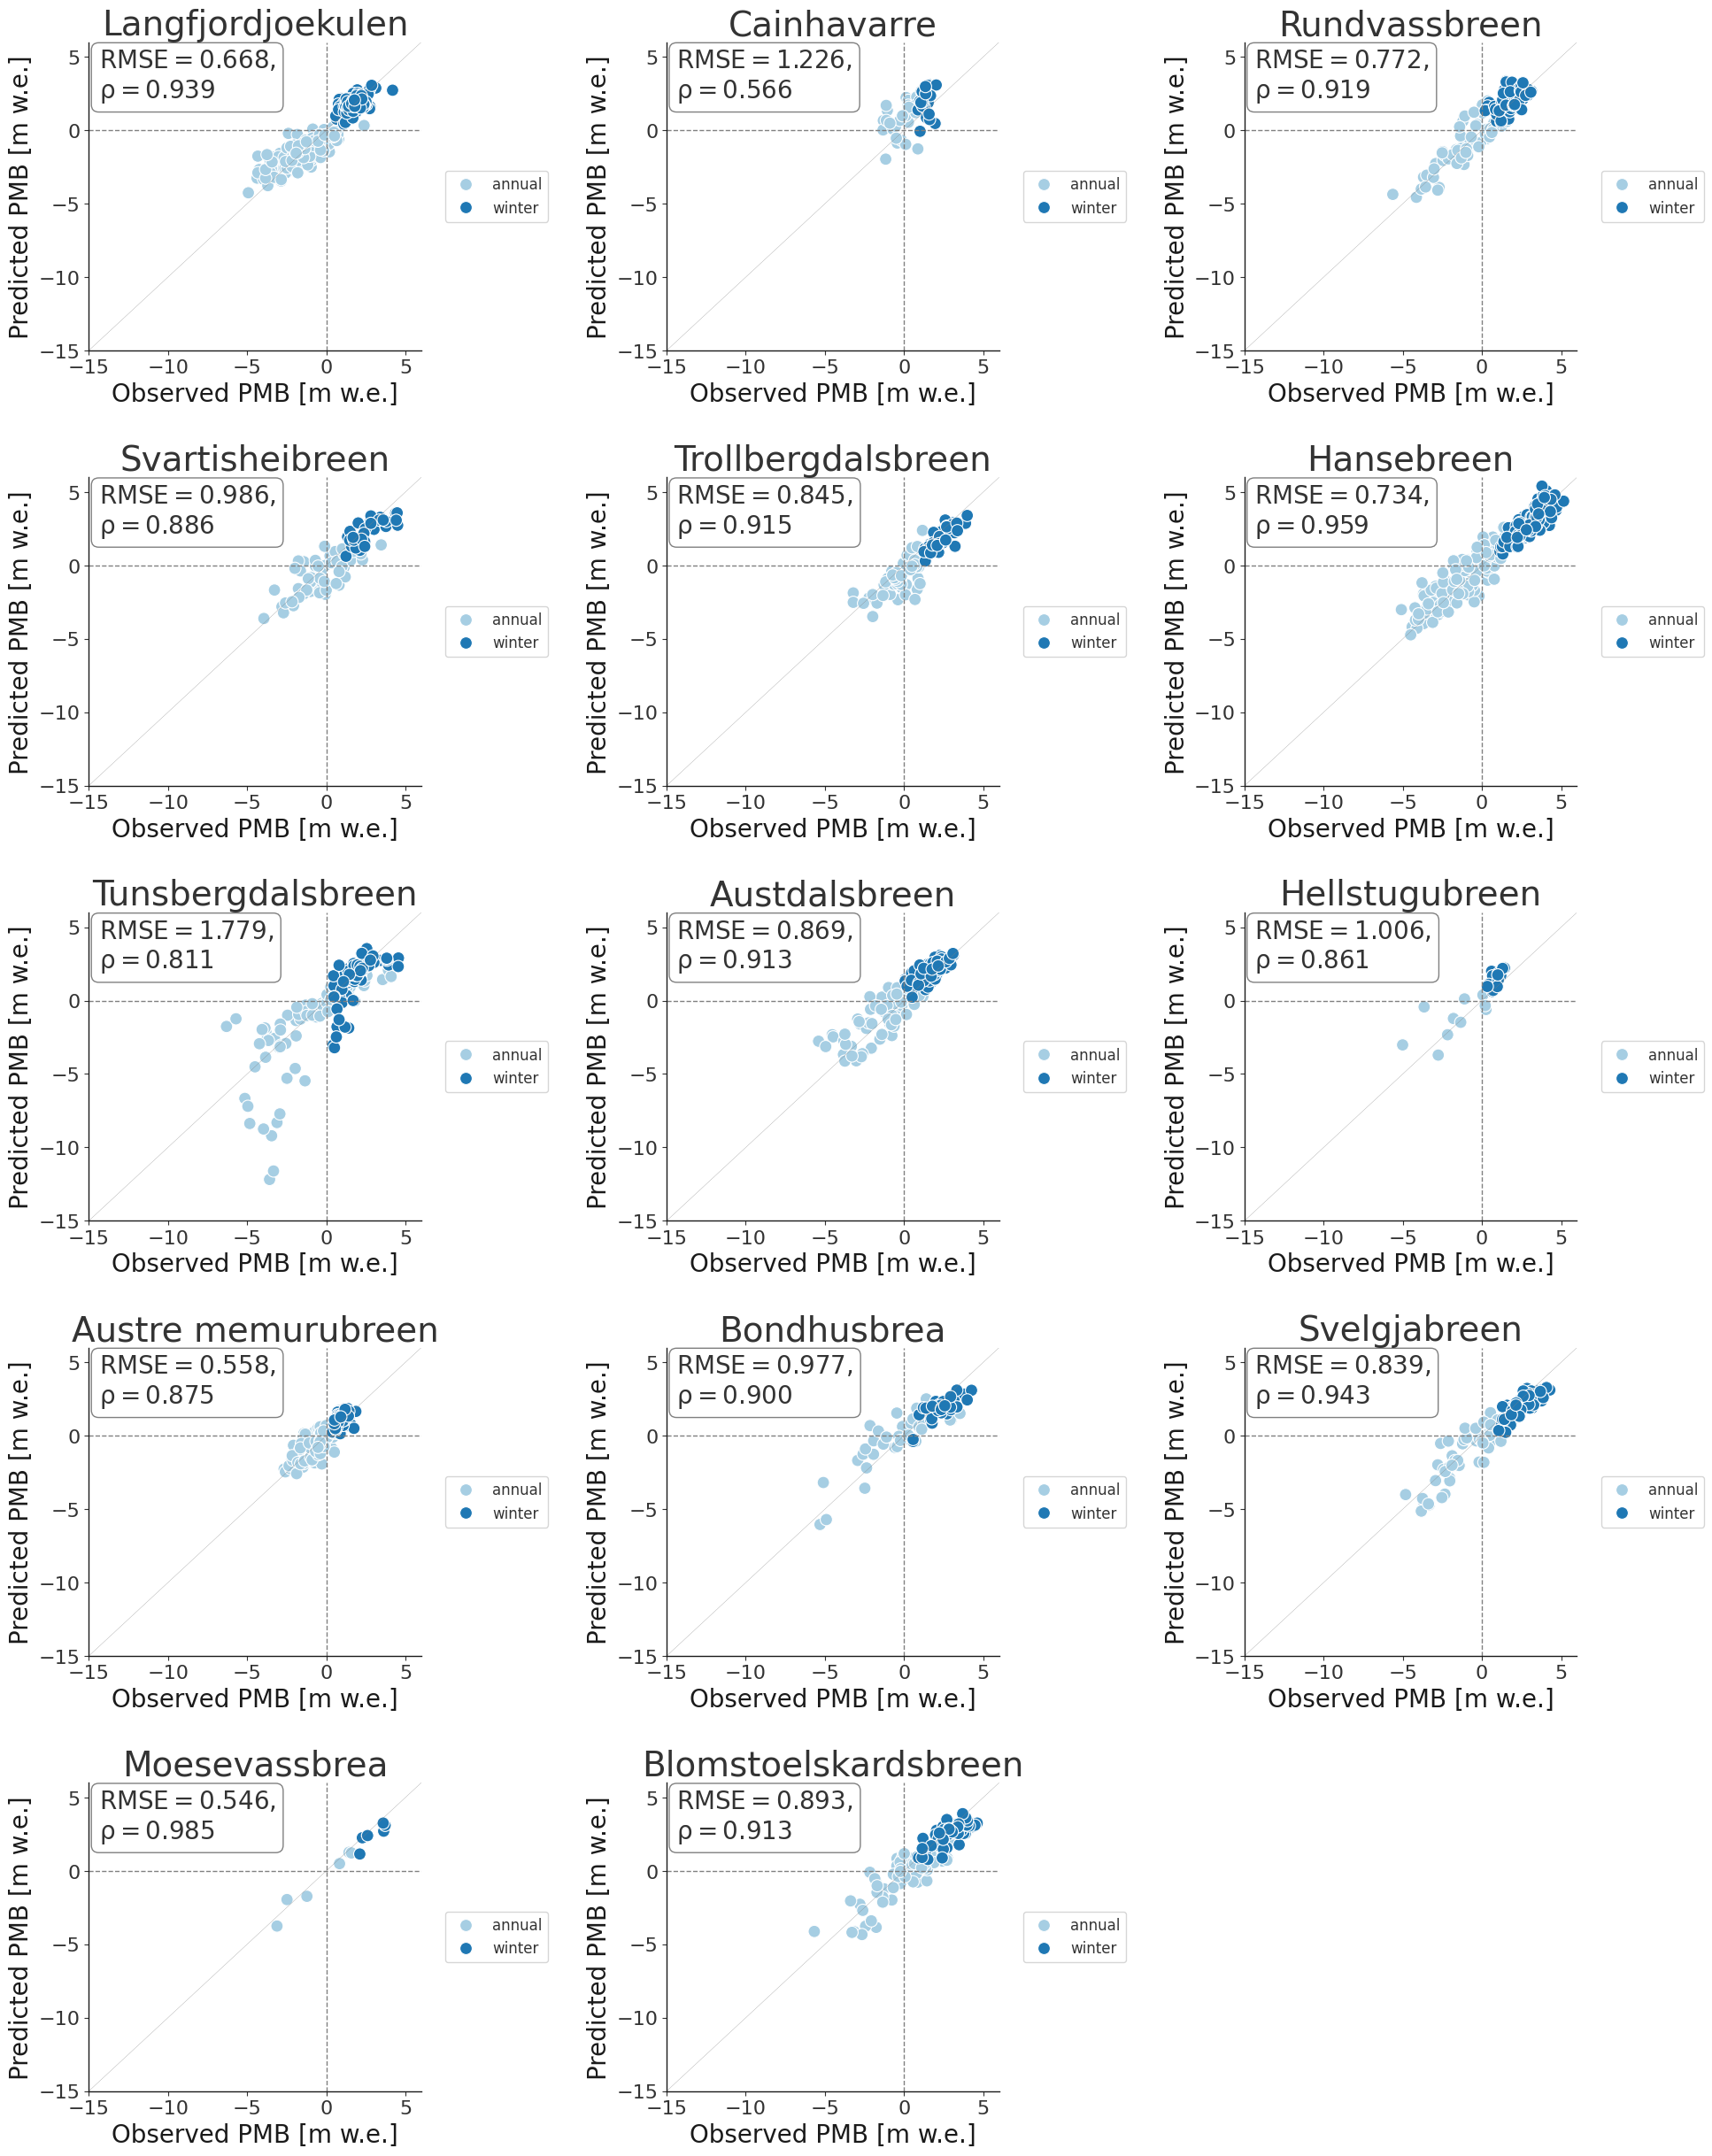

In [ ]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

In [ ]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='Prediction most recent 10 years')

In [21]:
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
display(grouped_ids_test[
    (grouped_ids_test['GLACIER'] == 'Tunsbergdalsbreen') & 
    (abs(grouped_ids_test['pmb_diff']) > 4)
])
display(grouped_ids_test[grouped_ids_test['POINT_ID'] == 'Tunsbergdalsbreen_1966_annual_2828'])



display(data_monthly[data_monthly['POINT_ID'] == 'Tunsbergdalsbreen_1966_annual_2828'])


target  YEAR                            POINT_ID       pred  PERIOD  \
ID                                                                          
2263   -3.11  1966  Tunsbergdalsbreen_1966_annual_2828  -8.305263  annual   
2296   -6.30  1969  Tunsbergdalsbreen_1969_annual_2861  -1.761666  annual   
2328   -3.58  1966  Tunsbergdalsbreen_1966_annual_2897 -12.181523  annual   
2334   -5.70  1972  Tunsbergdalsbreen_1972_annual_2903  -1.238497  annual   
2335   -3.33  1966  Tunsbergdalsbreen_1966_annual_2904 -11.604734  annual   
2336   -1.34  1967  Tunsbergdalsbreen_1967_annual_2905  -5.462611  annual   
2337   -3.45  1968  Tunsbergdalsbreen_1968_annual_2906  -9.205235  annual   
2339   -3.96  1970  Tunsbergdalsbreen_1970_annual_2908  -8.744212  annual   
2340   -2.93  1971  Tunsbergdalsbreen_1971_annual_2909  -7.717394  annual   

                GLACIER  pmb_diff  
ID                                 
2263  Tunsbergdalsbreen  5.195263  
2296  Tunsbergdalsbreen -4.538334  
2328  Tunsbergdalsbreen  8.601523  
2334  Tunsbergdalsbreen -4.461503  
2335  Tunsbergdalsbreen  8.274734  
2336  Tunsbergdalsbreen  4.122611  
2337  Tunsbergdalsbreen  5.755235  
2339  Tunsbergdalsbreen  4.784212  
2340  Tunsbergdalsbreen  4.787394

target  YEAR                            POINT_ID      pred  PERIOD  \
ID                                                                         
2263   -3.11  1966  Tunsbergdalsbreen_1966_annual_2828 -8.305263  annual   

                GLACIER  pmb_diff  
ID                                 
2263  Tunsbergdalsbreen  5.195263

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
27169  1966    7.13084   61.57567          -3.11       1194.305091   
27170  1966    7.13084   61.57567          -3.11       1194.305091   
27171  1966    7.13084   61.57567          -3.11       1194.305091   
27172  1966    7.13084   61.57567          -3.11       1194.305091   
27173  1966    7.13084   61.57567          -3.11       1194.305091   
27174  1966    7.13084   61.57567          -3.11       1194.305091   
27175  1966    7.13084   61.57567          -3.11       1194.305091   
27176  1966    7.13084   61.57567          -3.11       1194.305091   
27177  1966    7.13084   61.57567          -3.11       1194.305091   
27178  1966    7.13084   61.57567          -3.11       1194.305091   
27179  1966    7.13084   61.57567          -3.11       1194.305091   
27180  1966    7.13084   61.57567          -3.11       1194.305091   
27181  1966    7.13084   61.57567          -3.11       1194.305091   
27182  1966    7.13084   61.57567          -3.11       1194.305091   
27183  1966    7.13084   61.57567          -3.11       1194.305091   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
27169           -210.305091              984  RGI60-08.00434   
27170           -210.305091              984  RGI60-08.00434   
27171           -210.305091              984  RGI60-08.00434   
27172           -210.305091              984  RGI60-08.00434   
27173           -210.305091              984  RGI60-08.00434   
27174           -210.305091              984  RGI60-08.00434   
27175           -210.305091              984  RGI60-08.00434   
27176           -210.305091              984  RGI60-08.00434   
27177           -210.305091              984  RGI60-08.00434   
27178           -210.305091              984  RGI60-08.00434   
27179           -210.305091              984  RGI60-08.00434   
27180           -210.305091              984  RGI60-08.00434   
27181           -210.305091              984  RGI60-08.00434   
27182           -210.305091              984  RGI60-08.00434   
27183           -210.305091              984  RGI60-08.00434   

                                 POINT_ID    ID  ...  consensus_ice_thickness  \
27169  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27170  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27171  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27172  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27173  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27174  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27175  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27176  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27177  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27178  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27179  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27180  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27181  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27182  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   
27183  Tunsbergdalsbreen_1966_annual_2828  2263  ...               414.718536   

             t2m        tp       slhf      sshf        ssrd       fal  \
27169   1.705963  0.009428  -288058.0 -119774.0   6735201.5  0.739414   
27170   1.115143  0.006809   -55778.0   58448.0   3643454.5  0.746428   
27171 -12.658783  0.000998    15242.0   67474.0   1567148.0  0.824226   
27172 -17.051300  0.002287    19846.0  111730.0    585824.0  0.821298   
27173 -15.107635  0.002003    36146.0  228936.0   1145992.0  0.827365   
27174 -15.620331  0.001967    23174.0  148438.0   3826272.0  0.834193   
27175  -7.915192  0.006039    14010.0   46055.0   795

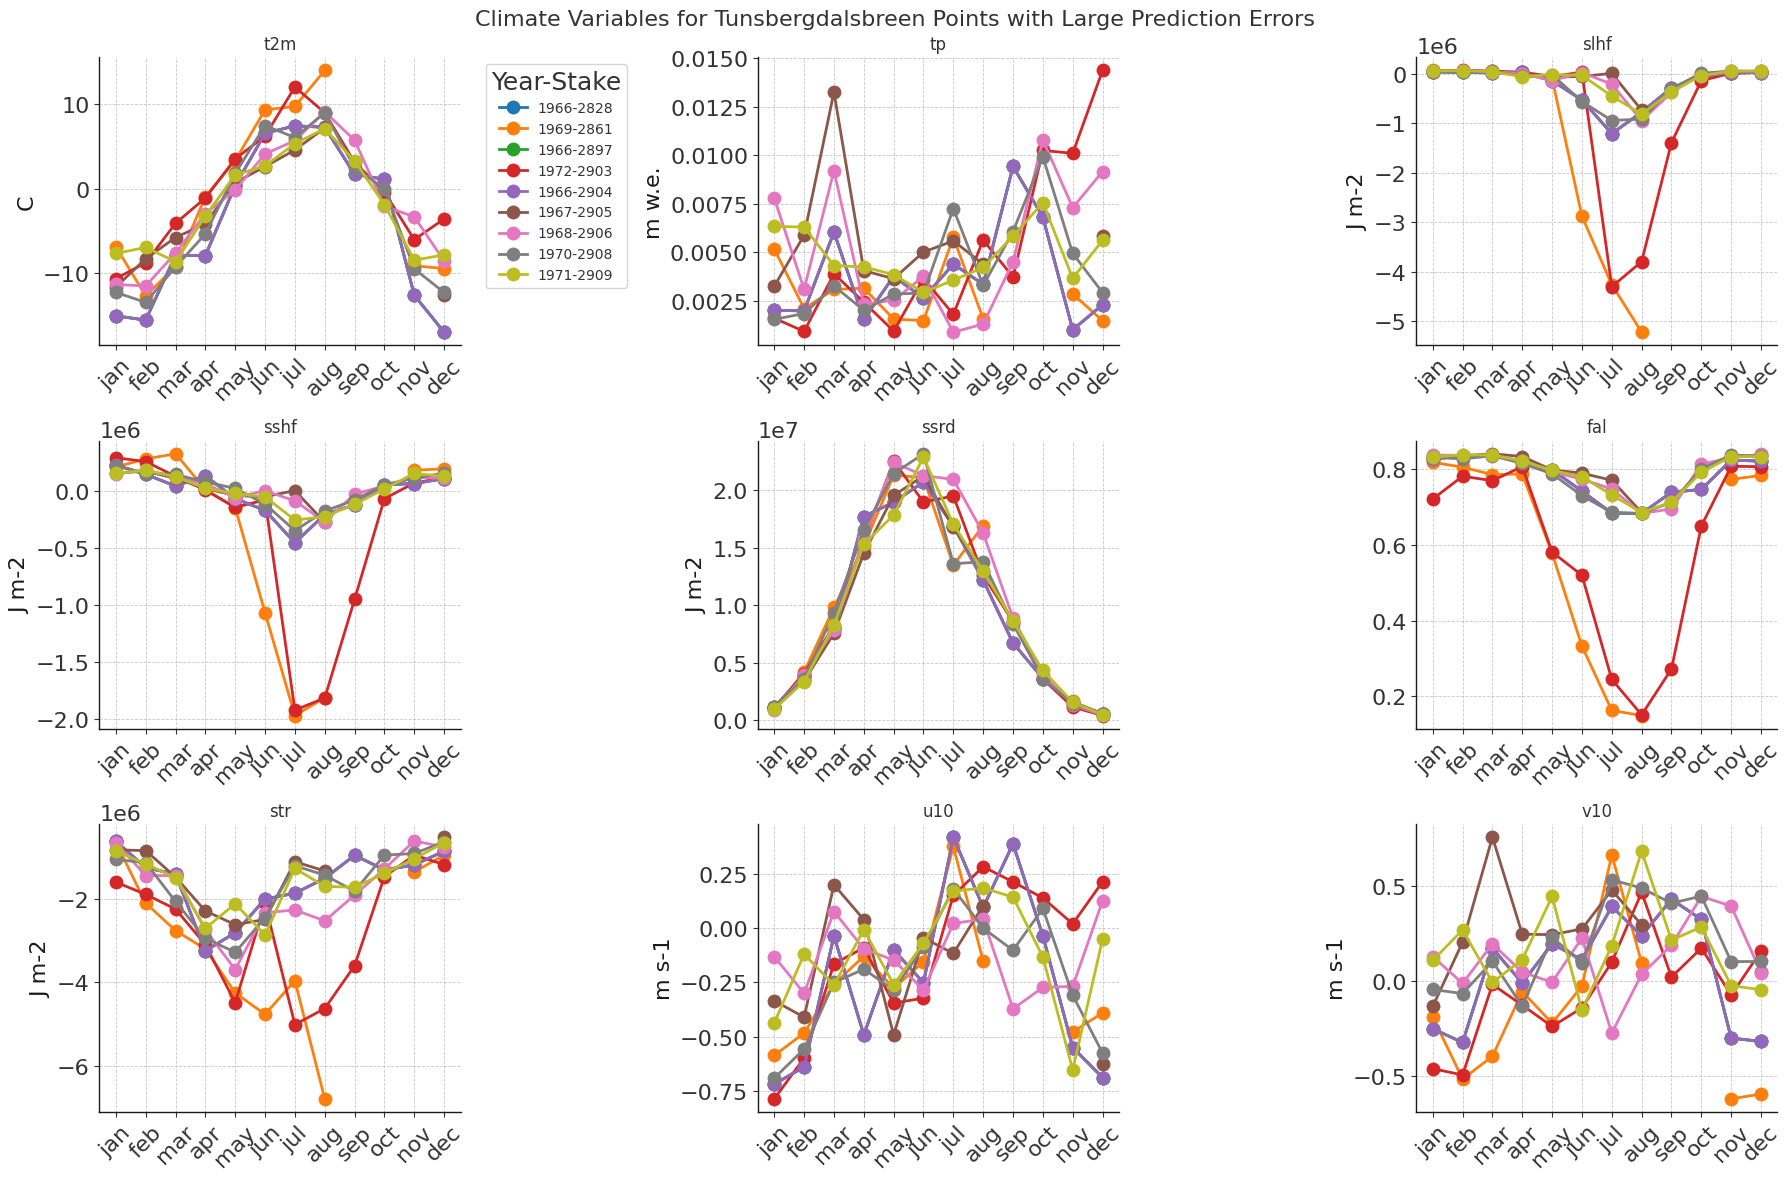

In [23]:
# List of specific Tunsbergdalsbreen point IDs from the provided data
point_ids = [
    'Tunsbergdalsbreen_1966_annual_2828',
    'Tunsbergdalsbreen_1969_annual_2861',
    'Tunsbergdalsbreen_1966_annual_2897',
    'Tunsbergdalsbreen_1972_annual_2903',
    'Tunsbergdalsbreen_1966_annual_2904',
    'Tunsbergdalsbreen_1967_annual_2905',
    'Tunsbergdalsbreen_1968_annual_2906',
    'Tunsbergdalsbreen_1970_annual_2908',
    'Tunsbergdalsbreen_1971_annual_2909'
]

# Filter data for these specific point IDs
tunsbergdalsbreen_data = data_monthly[data_monthly['POINT_ID'].isin(point_ids)]

plt.figure(figsize=(18, 12))

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Plot each climate variable
for var_idx, var in enumerate(vois_climate):
    ax = plt.subplot(3, 3, var_idx+1)
    
    # Group by point ID and month, taking mean if multiple values exist
    pivot_data = tunsbergdalsbreen_data.pivot_table(
        index='MONTHS', columns='POINT_ID', values=var, aggfunc='mean')
    
    for point_id in point_ids:
        if point_id in pivot_data.columns:
            # Get x and y values in correct month order
            valid_months = [m for m in month_order if m in pivot_data.index]
            if valid_months:
                x_pos = [month_order.index(m) for m in valid_months]
                y_vals = [pivot_data.loc[m, point_id] for m in valid_months]
                
                # Extract year and stake number for the label
                year = point_id.split('_')[1]
                stake = point_id.split('_')[3]
                
                ax.plot(x_pos, y_vals, marker='o', linewidth=2, label=f'{year}-{stake}')
    
    ax.set_title(f'{var}', fontsize=12)
    ax.set_ylabel(vois_units.get(var, ''))
    ax.set_xticks(range(len(month_order)))
    ax.set_xticklabels(month_order, rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend to first plot only
    if var_idx == 0:
        ax.legend(title='Year-Stake', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Climate Variables for Tunsbergdalsbreen Points with Large Prediction Errors', fontsize=16)
plt.tight_layout()
plt.show()

### B.1. Train CH Test FR

###### Load CH galciers and merge with NOR

In [27]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/GLAMOS/point/csv/CH_wgms_dataset_all.csv')
data_NOR = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/csv/Nor_dataset_all_oggm.csv')
display(data_NOR)

display(data_CH.columns)

display(data_NOR.columns)

data_CH = data_CH.drop(['millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with NOR
data_NOR_CH = pd.concat([data_NOR, data_CH], axis=0).reset_index(drop=True)

display(data_NOR_CH.head(2))

display(len(data_NOR_CH['GLACIER'].unique()))

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  \
0      70.12589   21.77702              471   20120925  20131107   
1      70.12578   21.77630              439   20131107  20140924   
2      70.12573   21.77590              444   20140924  20150923   
3      70.12573   21.77590              444   20150923  20160922   
4      70.12554   21.77352              468   20160922  20170929   
...         ...        ...              ...        ...       ...   
6292   59.93803    6.34733             1078   20111001  20120503   
6293   59.93789    6.34729             1078   20121012  20130529   
6294   59.93815    6.34702             1079   20141014  20150422   
6295   59.93803    6.34724             1078   20151014  20160428   
6296   59.93791    6.34738             1078   20161006  20170502   

      POINT_BALANCE  PERIOD           RGIId  YEAR               GLACIER  \
0             -4.92  annual  RGI60-08.01258  2013     Langfjordjoekulen   
1             -2.67  annual  RGI60-08.01258  2014     Langfjordjoekulen   
2             -3.41  annual  RGI60-08.01258  2015     Langfjordjoekulen   
3             -3.59  annual  RGI60-08.01258  2016     Langfjordjoekulen   
4             -2.46  annual  RGI60-08.01258  2017     Langfjordjoekulen   
...             ...     ...             ...   ...                   ...   
6292           1.50  winter  RGI60-08.02969  2012  Blomstoelskardsbreen   
6293           1.14  winter  RGI60-08.02969  2013  Blomstoelskardsbreen   
6294           1.19  winter  RGI60-08.02969  2015  Blomstoelskardsbreen   
6295           1.72  winter  RGI60-08.02969  2016  Blomstoelskardsbreen   
6296           1.15  winter  RGI60-08.02969  2017  Blomstoelskardsbreen   

          aspect      slope         topo  hugonnet_dhdt  \
0      36.073272  15.972541   425.458893      -3.314563   
1      33.570984  16.993369   434.652008      -2.934460   
2      38.002076  17.332428   441.768280      -2.923457   
3      38.002076  17.332428   441.768280      -2.923457   
4      47.942662  17.715600   458.299377      -2.962617   
...          ...        ...          ...            ...   
6292  166.504029   7.546811  1093.000000      -1.385310   
6293  166.504029   7.546811  1093.000000      -1.385310   
6294  166.504029   7.546811  1093.000000      -1.385310   
6295  166.504029   7.546811  1093.000000      -1.385310   
6296  166.504029   7.546811  1093.000000      -1.385310   

      consensus_ice_thickness                               POINT_ID  
0                   96.980293        Langfjordjoekulen_2013_annual_0  
1                   89.294670        Langfjordjoekulen_2014_annual_1  
2                   90.894768        Langfjordjoekulen_2015_annual_2  
3                   90.894768        Langfjordjoekulen_2016_annual_3  
4                   97.562950        Langfjordjoekulen_2017_annual_4  
...                       ...                                    ...  
6292                68.130363  Blomstoelskardsbreen_2012_winter_7656  
6293                68.130363  Blomstoelskardsbreen_2013_winter_7657  
6294                68.130363  Blomstoelskardsbreen_2015_winter_7658  
6295                68.130363  Blomstoelskardsbreen_2016_winter_7659  
6296                68.130363  Blomstoelskardsbreen_2017_winter_7660  

[6297 rows x 16 columns]

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER', 'aspect',
       'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'POINT_ID'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0   70.12589   21.77702            471.0   20120925  20131107          -4.92   
1   70.12578   21.77630            439.0   20131107  20140924          -2.67   

   PERIOD           RGIId  YEAR            GLACIER     aspect      slope  \
0  annual  RGI60-08.01258  2013  Langfjordjoekulen  36.073272  15.972541   
1  annual  RGI60-08.01258  2014  Langfjordjoekulen  33.570984  16.993369   

         topo  hugonnet_dhdt  consensus_ice_thickness  \
0  425.458893      -3.314563                96.980293   
1  434.652008      -2.934460                89.294670   

                          POINT_ID  
0  Langfjordjoekulen_2013_annual_0  
1  Langfjordjoekulen_2014_annual_1

71

In [ ]:
data_CH_NOR_test = data_NOR_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_NOR_wgms_dataset_monthly_full.csv')
data_monthly_CH_NOR = dataloader_gl.data

display(data_monthly_CH_NOR.head(2))

(39655, 16)

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0   70.12589   21.77702            471.0   20120925  20131107          -4.92   
1   70.12578   21.77630            439.0   20131107  20140924          -2.67   

   PERIOD           RGIId  YEAR            GLACIER     aspect      slope  \
0  annual  RGI60-08.01258  2013  Langfjordjoekulen  36.073272  15.972541   
1  annual  RGI60-08.01258  2014  Langfjordjoekulen  33.570984  16.993369   

         topo  hugonnet_dhdt  consensus_ice_thickness  \
0  425.458893      -3.314563                96.980293   
1  434.652008      -2.934460                89.294670   

                          POINT_ID  
0  Langfjordjoekulen_2013_annual_0  
1  Langfjordjoekulen_2014_annual_1

2025-06-01 13:16:04,020 - INFO - Loaded preprocessed data.
2025-06-01 13:16:04,022 - INFO - Number of monthly rows: 361383
2025-06-01 13:16:04,051 - INFO - Number of annual rows: 132331
2025-06-01 13:16:04,086 - INFO - Number of winter rows: 229052


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2013   21.77702   70.12589          -4.92        341.344485   
1  2013   21.77702   70.12589          -4.92        341.344485   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            129.655515            471.0  RGI60-08.01258   
1            129.655515            471.0  RGI60-08.01258   

                          POINT_ID  ID  ...  consensus_ice_thickness  \
0  Langfjordjoekulen_2013_annual_0   0  ...                96.980293   
1  Langfjordjoekulen_2013_annual_0   0  ...                96.980293   

        t2m        tp      slhf      sshf       ssrd       fal        str  \
0 -0.428070  0.003846  -55354.0  657502.0  2040907.0  0.439741 -2504336.0   
1 -4.780853  0.003902  178386.0  909366.0   157664.0  0.817481 -1714196.0   

        u10       v10  
0 -0.141248  0.397857  
1 -0.183276  1.758524  

[2 rows x 27 columns]

In [ ]:
test_glaciers = list(data_NOR['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

#### B.2.2. XGBoost Transfer Region

In [32]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    #"millan_v",
]

#### Grid Search

In [33]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'CH_train_NOR_test.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'CH_train_NOR_test.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (301118, 25)
Shape of testing dataset: (60265, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.2039305227297354
Shape of the test: (60265, 14)
Overall score: 2.9116013133486205
CPU times: user 4.97 s, sys: 111 ms, total: 5.08 s
Wall time: 646 ms


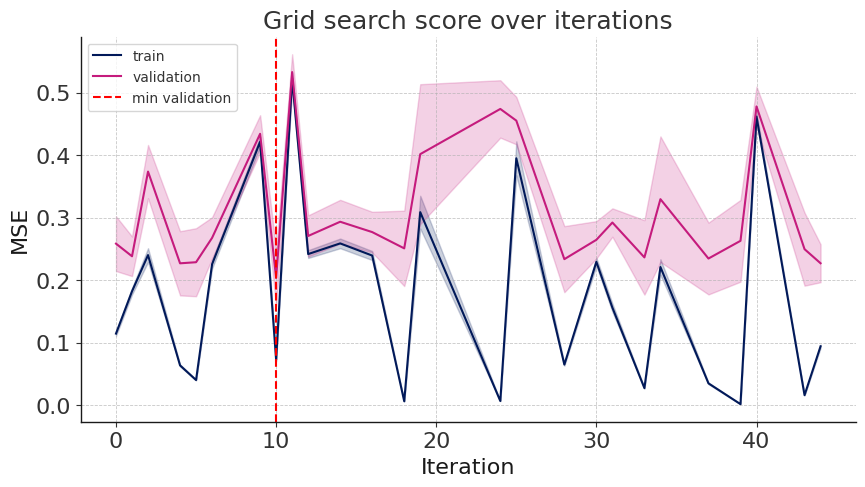

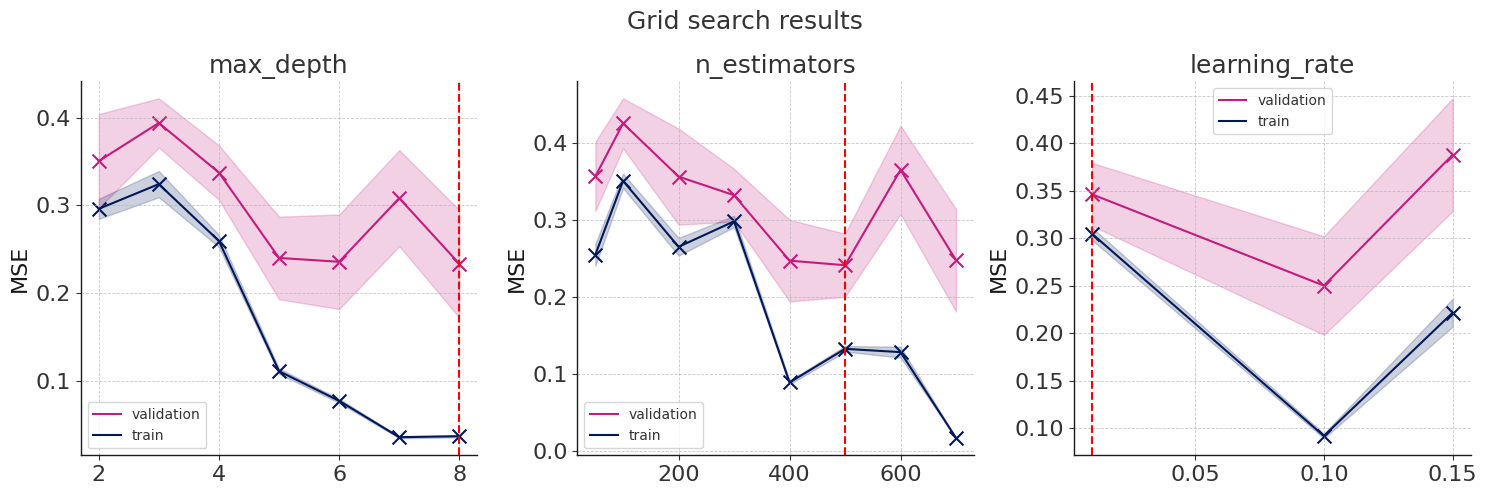

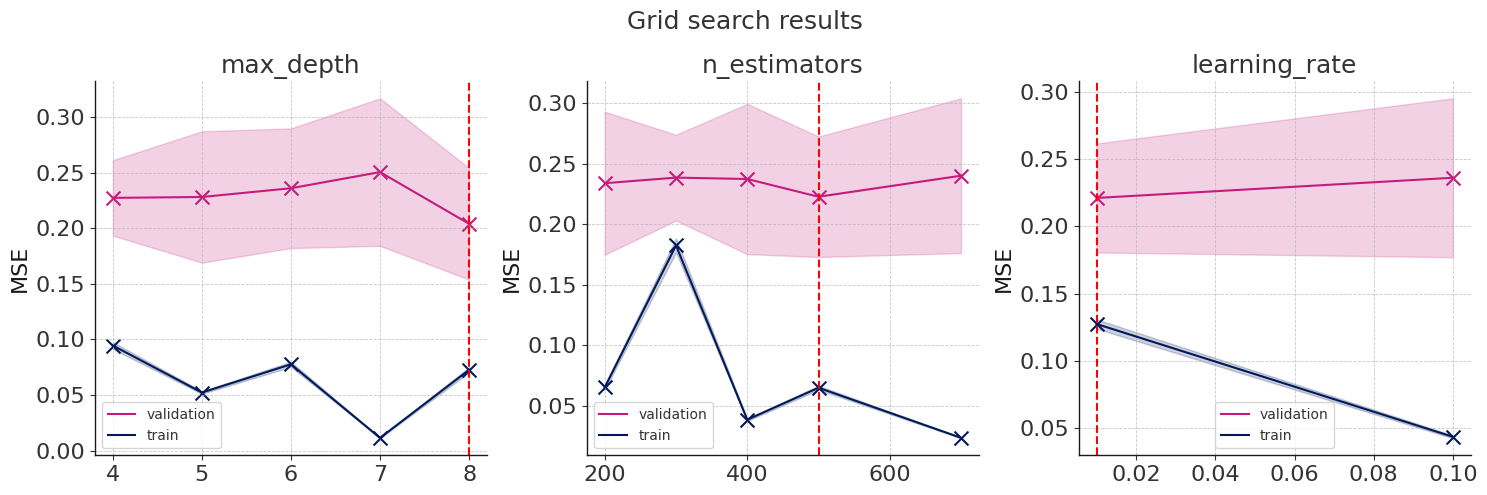

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

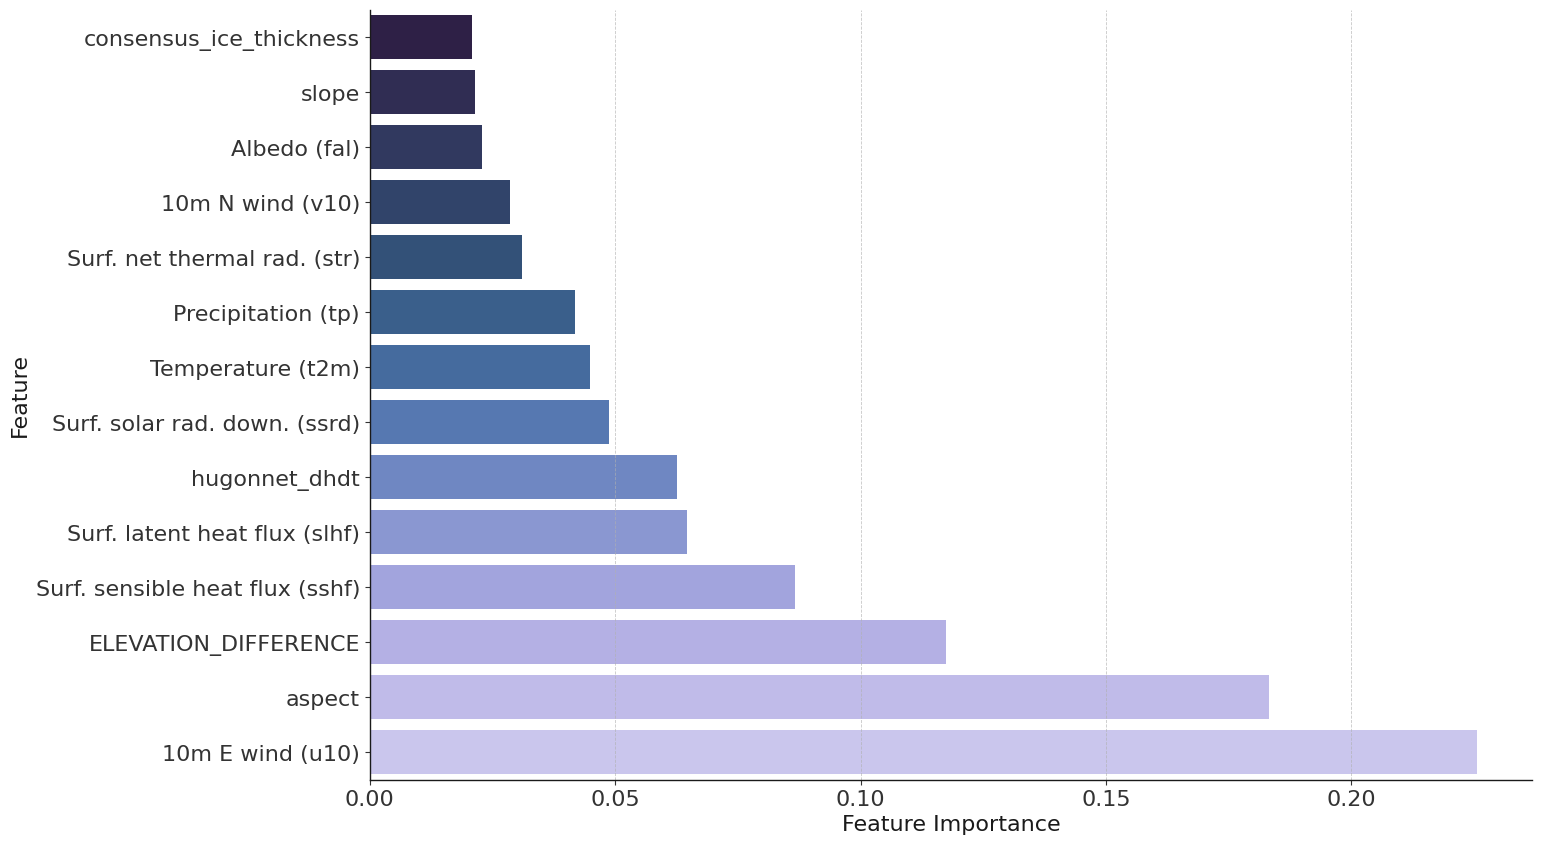

In [35]:
FIPlot(best_estimator, feature_columns, vois_climate)

Shape of the test: (60265, 14)
{'Langfjordjoekulen': '#a6cee3', 'Blaaisen': '#1f78b4', 'Storsteinsfjellbreen': '#b2df8a', 'Cainhavarre': '#33a02c', 'Rundvassbreen': '#fb9a99', 'Storglombreen N': '#e31a1c', 'Engabreen': '#fdbf6f', 'Svartisheibreen': '#ff7f00', 'Hoegtuvbreen': '#cab2d6', 'Trollbergdalsbreen': '#6a3d9a', 'Aalfotbreen': '#ffff99', 'Hansebreen': '#b15928', 'Vetlefjordbreen': '#8dd3c7', 'Nigardsbreen': '#ffffb3', 'Tunsbergdalsbreen': '#bebada', 'Vesledalsbreen': '#fb8072', 'Austdalsbreen': '#80b1d3', 'Harbardsbreen': '#fdb462', 'Juvfonne': '#b3de69', 'Graasubreen': '#fccde5', 'Hellstugubreen': '#d9d9d9', 'Austre Memurubreen': '#bc80bd', 'Vestre Memurubreen': '#ccebc5', 'Rembesdalskaaka': '#ffed6f', 'Blabreen': '#66c2a5', 'Graafjellsbrea': '#fc8d62', 'Breidablikkbrea': '#8da0cb', 'Ruklebreen': '#e78ac3', 'Bondhusbrea': '#a6d854', 'Svelgjabreen': '#ffd92f', 'Moesevassbrea': '#e5c494', 'Blomstoelskardsbreen': '#b3b3b3'}


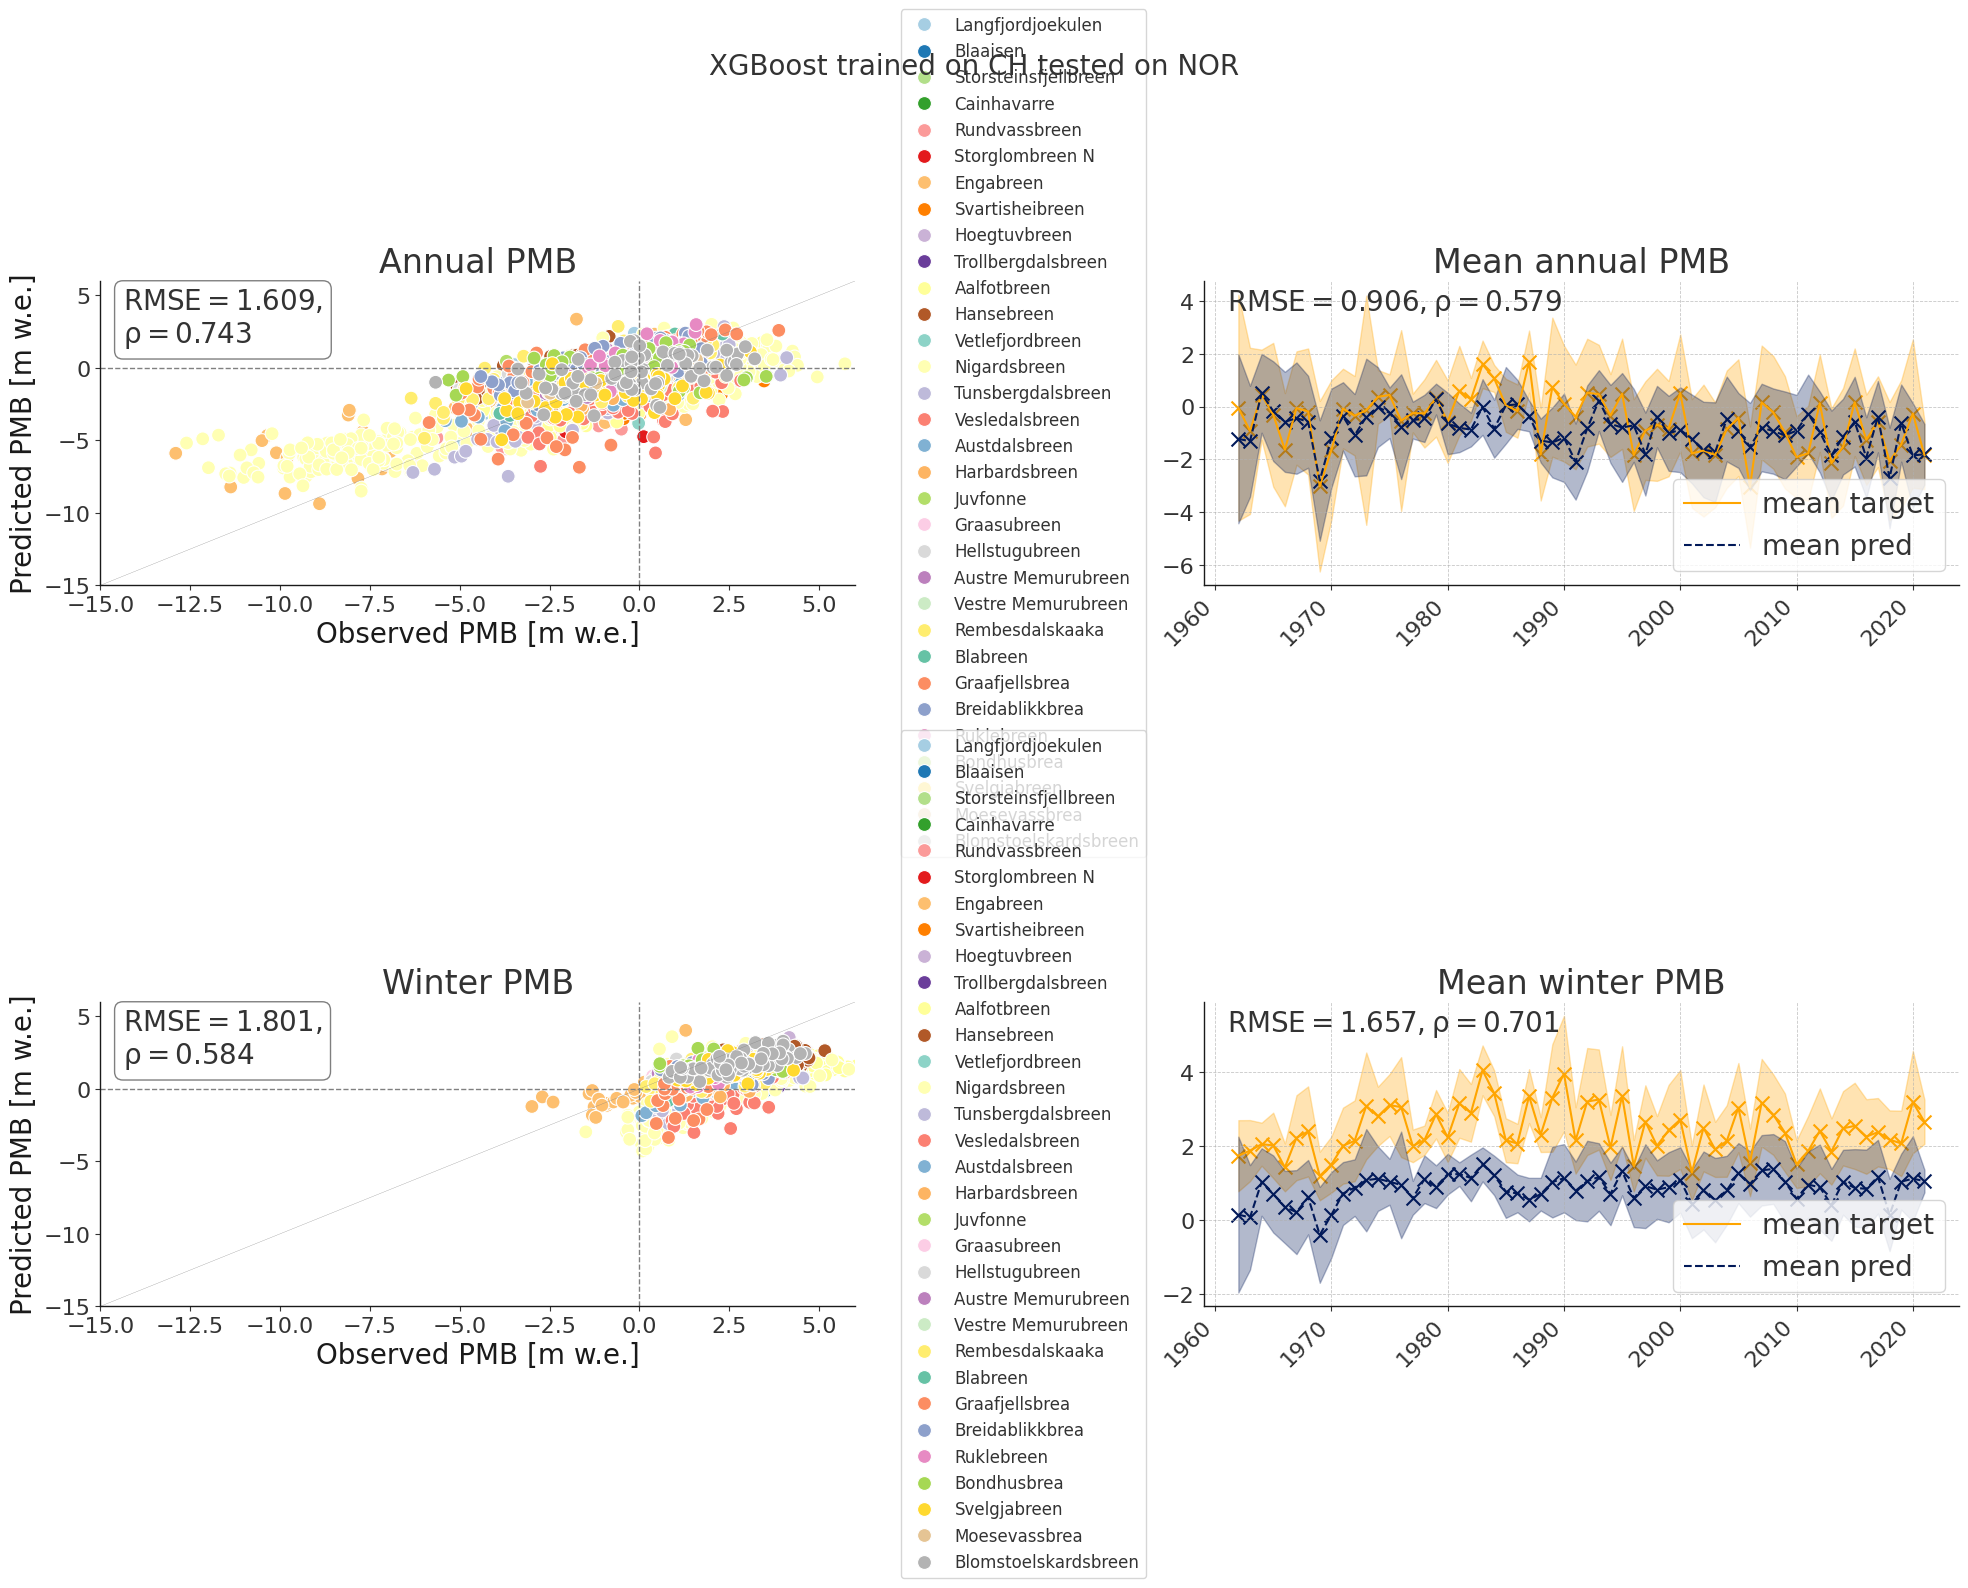

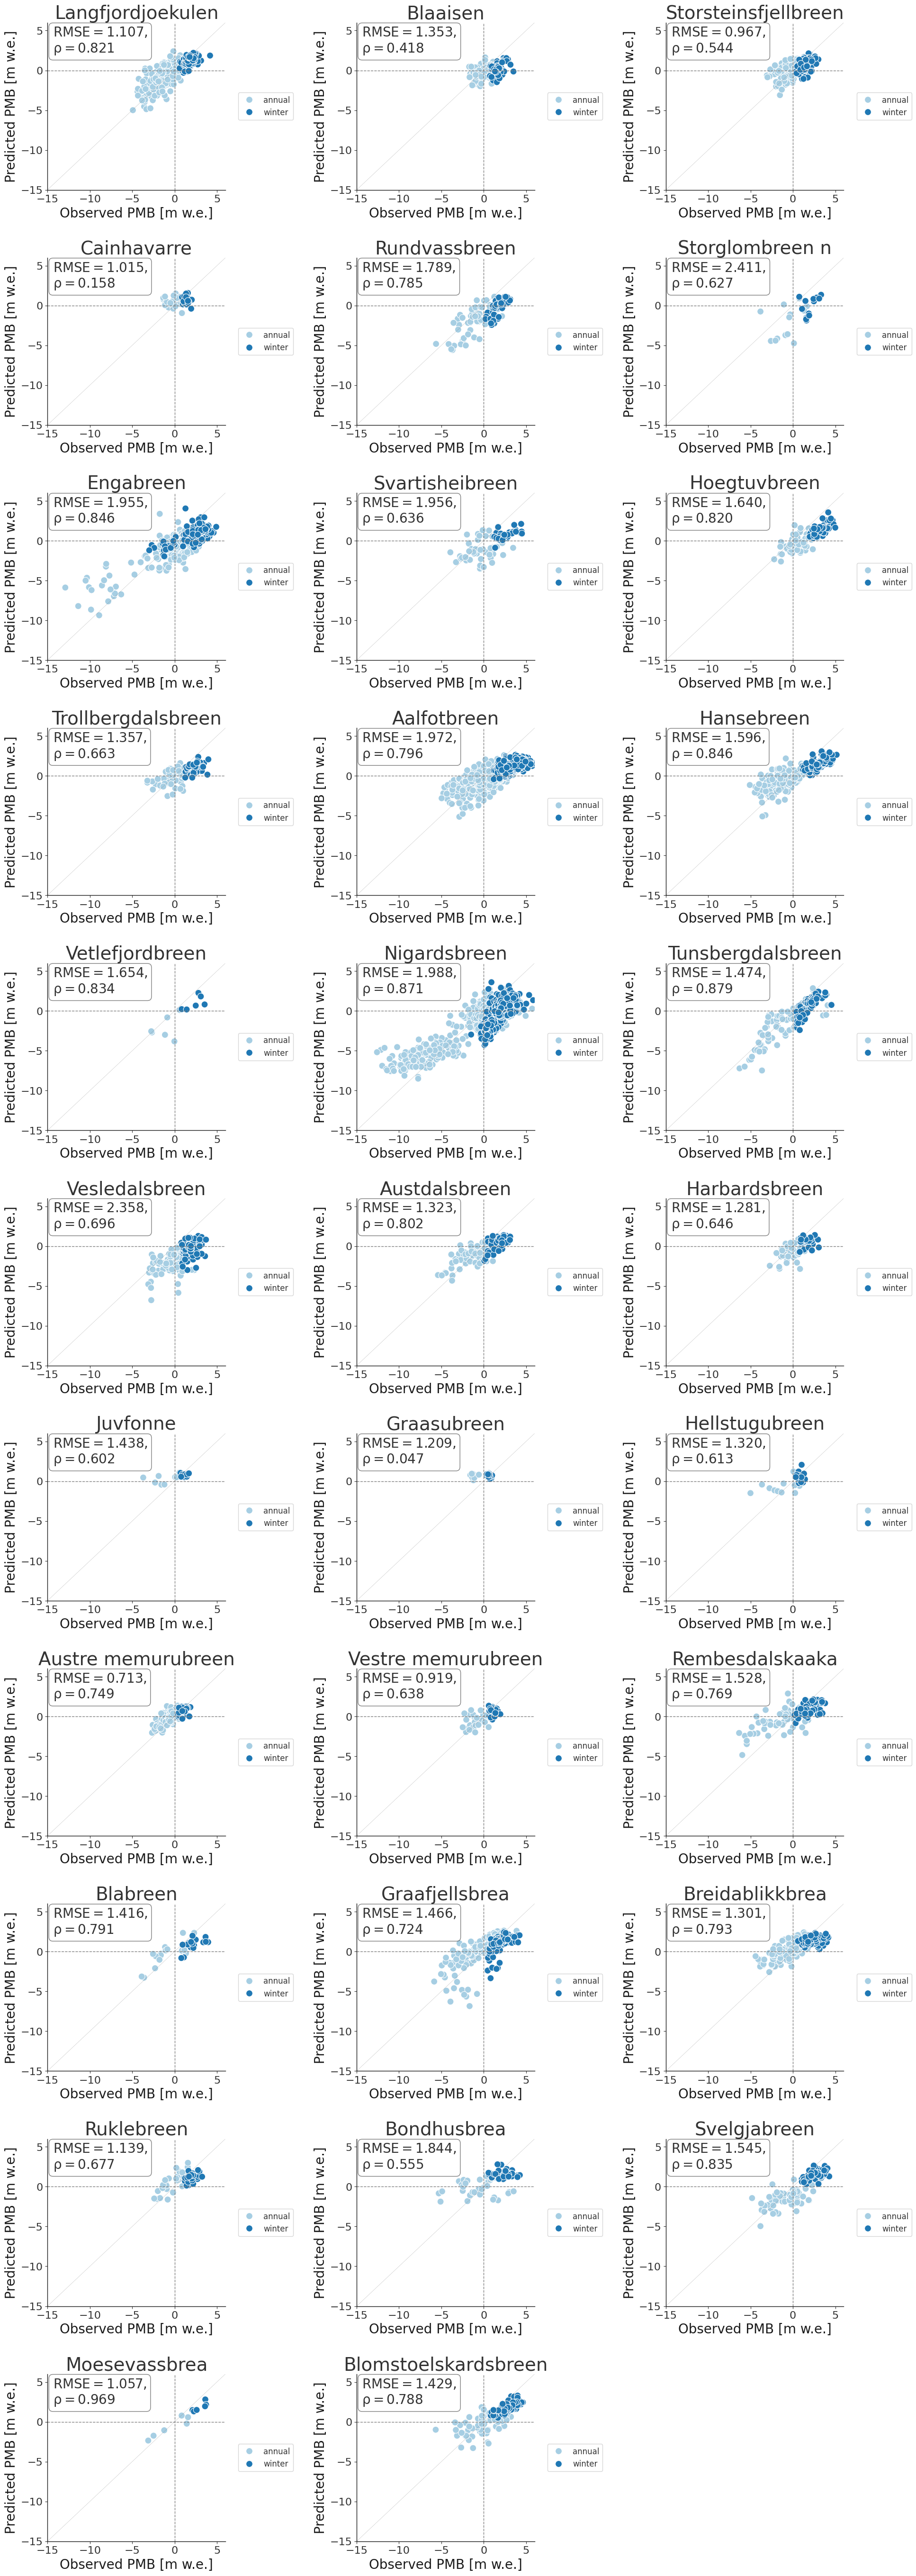

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)


PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

In [ ]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

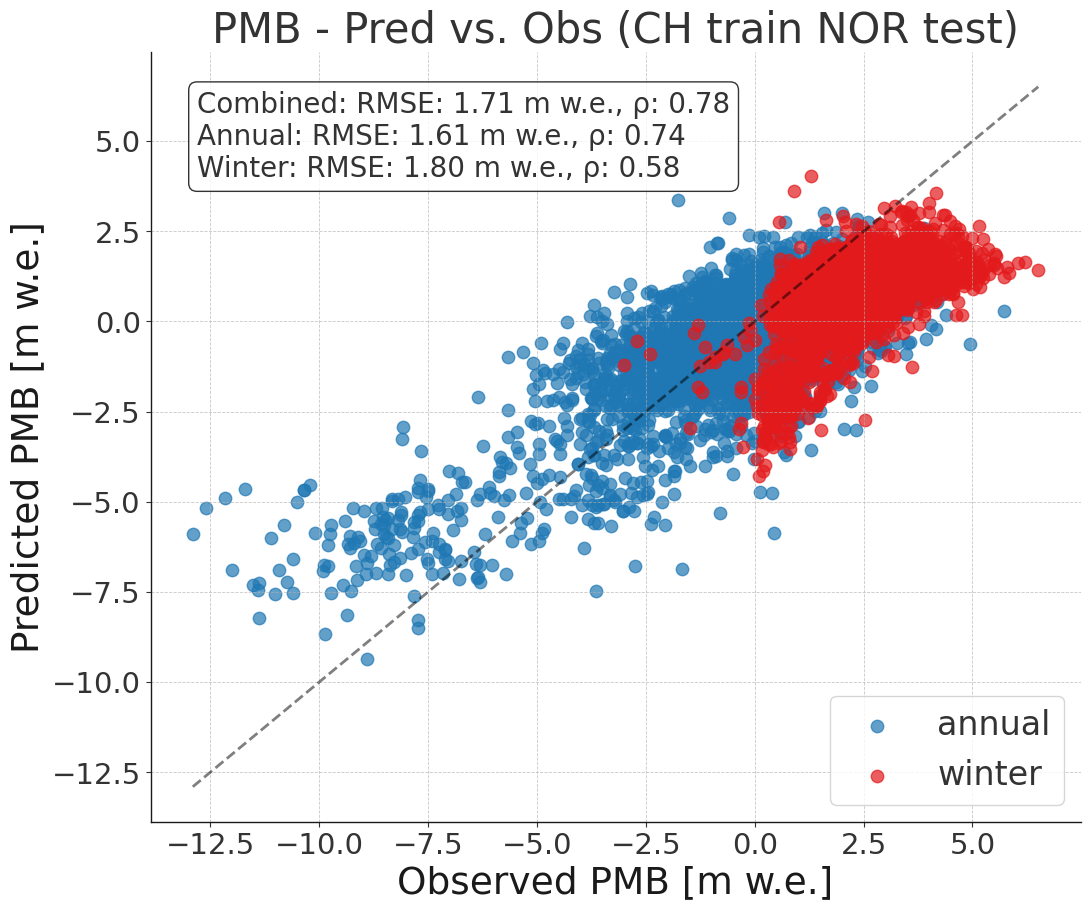

In [ ]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train NOR Test', include_summer = False)

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

FIPlot(custom_model, feature_columns, vois_climate)